# Figures and code for Lauderdale & Cael "Remineralization profile shape and the air-sea carbon balance"

In [1]:
from matplotlib    import pyplot  as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy         import special as sp

import cmocean     as cm
import getpass     as gp
import glob        as gb
import matplotlib  as mp
import netCDF4     as nc
import numpy       as np
import numpy.ma    as nm
import pandas      as pd
import scipy.stats as st
import xarray      as xr
import csv
import mitgcm_tools
import warnings

plt.rcParams['xtick.labelsize'] ='large'
plt.rcParams['ytick.labelsize'] ='large'
plt.rcParams['axes.labelsize' ] ='large'
plt.rcParams['legend.fontsize'] ='large'
plt.rcParams['figure.titlesize']='large'
plt.rcParams['font.size']       ='13'

def flip(items, ncol):
    import itertools
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

def label_axes(axarray,ignore=None,label_columns=False):
    import string      as st
    m=0
    
    if label_columns:
        axarray=np.transpose(axarray)
    
    for n, ax in enumerate(axarray.flat):
        if ignore is not None and n in ignore:
            m+=1
            continue
        else:
            ax.text(-0.1, 1.05, st.ascii_uppercase[n-m], transform=ax.transAxes, 
                    size=20, weight='bold')

def get_point_attributes(path):
    mycmap = plt.cm.get_cmap(mp.cm.tab10)

    if not path.strip():
        facecolor='#ffffff'
        edgecolor='#ffffff'
        label    =''        
    elif path.split('/')[-3].find("exp")!=-1:
        facecolor= mycmap(1) #'#ff7f0e'
        edgecolor='#000000'
        label    ='Exponential'
    elif path.split('/')[-3].find("bal")!=-1:
        facecolor= mycmap(2) #'#2ca02c'
        edgecolor='#000000'
        label    ='Ballast'
    elif path.split('/')[-3].find("dbl")!=-1:
        facecolor= mycmap(3) #'#9467bd'
        edgecolor='#000000'
        label    ='Double'
    elif path.split('/')[-3].find("str")!=-1:
        facecolor= mycmap(4) #'#8c564b'
        edgecolor='#000000'
        label    ='Stretched'
    elif path.split('/')[-3].find("rat")!=-1:
        facecolor= mycmap(5) #'#d62728'
        edgecolor='#000000'
        label    ='Rational'
    elif path.split('/')[-3].find("gam")!=-1:
        facecolor= mycmap(6) #'#e377c2'
        edgecolor='#000000'
        label    ='Gamma'
    else: # Martin curve points
        facecolor='#1f77b4'
        if   path.split('/')[-3].find("1.0")!=-1:
#            edgecolor='#1f77b4'
            edgecolor='#000000'
            label    ='Power (b=1.0)'
            mark     ='o'
        elif path.split('/')[-3].find("0.9")!=-1:
            #edgecolor='#000000'
            edgecolor='#000000'
            label    ='Power (b=0.98)'
            mark     ='p'
        elif path.split('/')[-3].find("0.8")!=-1:
            #edgecolor='#ff0000'
            edgecolor='#000000'
            label    ='Power (b=0.84)'
            mark     ='P'
        elif path.split('/')[-3].find("0.7")!=-1:
            #edgecolor='#ffffff'
            edgecolor='#000000'
            label    ='Power (b=0.70)'
            mark     ='d'
    
    if not path.strip():
        mark=','
        memb=" "
    elif path.split('/')[-3].find("abs")!=-1:
        mark='s'
        memb="Minimizing absolute error (AFIT)"
    elif path.split('/')[-3].find("rel")!=-1:
        mark='o'
        memb="Minimizing relative error (RFIT)"
    elif path.split('/')[-3].find("efd")!=-1:
        mark='^'
        memb="Fixed e-folding depth (EFD)"
    else: # Martin curve points
#        mark='o'
        memb="Martin"
    return facecolor, edgecolor, mark, label, memb

# https://stackoverflow.com/questions/25830780/tabular-legend-layout-for-matplotlib/60345118#60345118
# For a tabulated legend
def tablelegend(ax, col_labels=None, row_labels=None, title_label="", *args, **kwargs):
    import matplotlib.legend as mlegend
    from matplotlib.patches import Rectangle
    """
    Place a table legend on the axes.

    Creates a legend where the labels are not directly placed with the artists, 
    but are used as row and column headers, looking like this:

    title_label   | col_labels[1] | col_labels[2] | col_labels[3]
    -------------------------------------------------------------
    row_labels[1] |
    row_labels[2] |              <artists go there>
    row_labels[3] |


    Parameters
    ----------

    ax : `matplotlib.axes.Axes`
        The artist that contains the legend table, i.e. current axes instant.

    col_labels : list of str, optional
        A list of labels to be used as column headers in the legend table.
        `len(col_labels)` needs to match `ncol`.

    row_labels : list of str, optional
        A list of labels to be used as row headers in the legend table.
        `len(row_labels)` needs to match `len(handles) // ncol`.

    title_label : str, optional
        Label for the top left corner in the legend table.

    ncol : int
        Number of columns.


    Other Parameters
    ----------------

    Refer to `matplotlib.legend.Legend` for other parameters.

    """
    #################### same as `matplotlib.axes.Axes.legend` #####################
    handles, labels, extra_args, kwargs = mlegend._parse_legend_args([ax], *args, **kwargs)
    if len(extra_args):
        raise TypeError('legend only accepts two non-keyword arguments')

    if col_labels is None and row_labels is None:
        ax.legend_ = mlegend.Legend(ax, handles, labels, **kwargs)
        ax.legend_._remove_method = ax._remove_legend
        return ax.legend_
    #################### modifications for table legend ############################
    else:
        ncol = kwargs.pop('ncol')
        handletextpad = kwargs.pop('handletextpad', 0 if col_labels is None else -2)
        title_label = [title_label]

        # blank rectangle handle
        extra = [Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)]

        # empty label
        empty = [""]

        # number of rows infered from number of handles and desired number of columns
        nrow = len(handles) // ncol

        # organise the list of handles and labels for table construction
        if col_labels is None:
            assert nrow == len(row_labels), "nrow = len(handles) // ncol = %s, but should be equal to len(row_labels) = %s." % (nrow, len(row_labels))
            leg_handles = extra * nrow
            leg_labels  = row_labels
        elif row_labels is None:
            assert ncol == len(col_labels), "ncol = %s, but should be equal to len(col_labels) = %s." % (ncol, len(col_labels))
            leg_handles = []
            leg_labels  = []
        else:
            assert nrow == len(row_labels), "nrow = len(handles) // ncol = %s, but should be equal to len(row_labels) = %s." % (nrow, len(row_labels))
            assert ncol == len(col_labels), "ncol = %s, but should be equal to len(col_labels) = %s." % (ncol, len(col_labels))
            leg_handles = extra + extra * nrow
            leg_labels  = title_label + row_labels
        for col in range(ncol):
            if col_labels is not None:
                leg_handles += extra
                leg_labels  += [col_labels[col]]
            leg_handles += handles[col*nrow:(col+1)*nrow]
            leg_labels  += empty * nrow

        # Create legend
        ax.legend_ = mlegend.Legend(ax, leg_handles, leg_labels, ncol=ncol+int(row_labels is not None), handletextpad=handletextpad, **kwargs)
        ax.legend_._remove_method = ax._remove_legend
        return ax.legend_

def label_bars(rects,ax,**kwargs):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height>=0:
            align='bottom'
            mod=+0.1
        else:
            align='top'
            mod=-2
        ax.text(rect.get_x() + rect.get_width()/2., height+mod,
               # '%d' % int(height),
                np.round(height,1),
                ha='center', va=align,**kwargs)

## Plot the different export models: Power Law, Exponential, Ballast, Rational, Double Exponential, Stretched Eponential, and Gamma Function

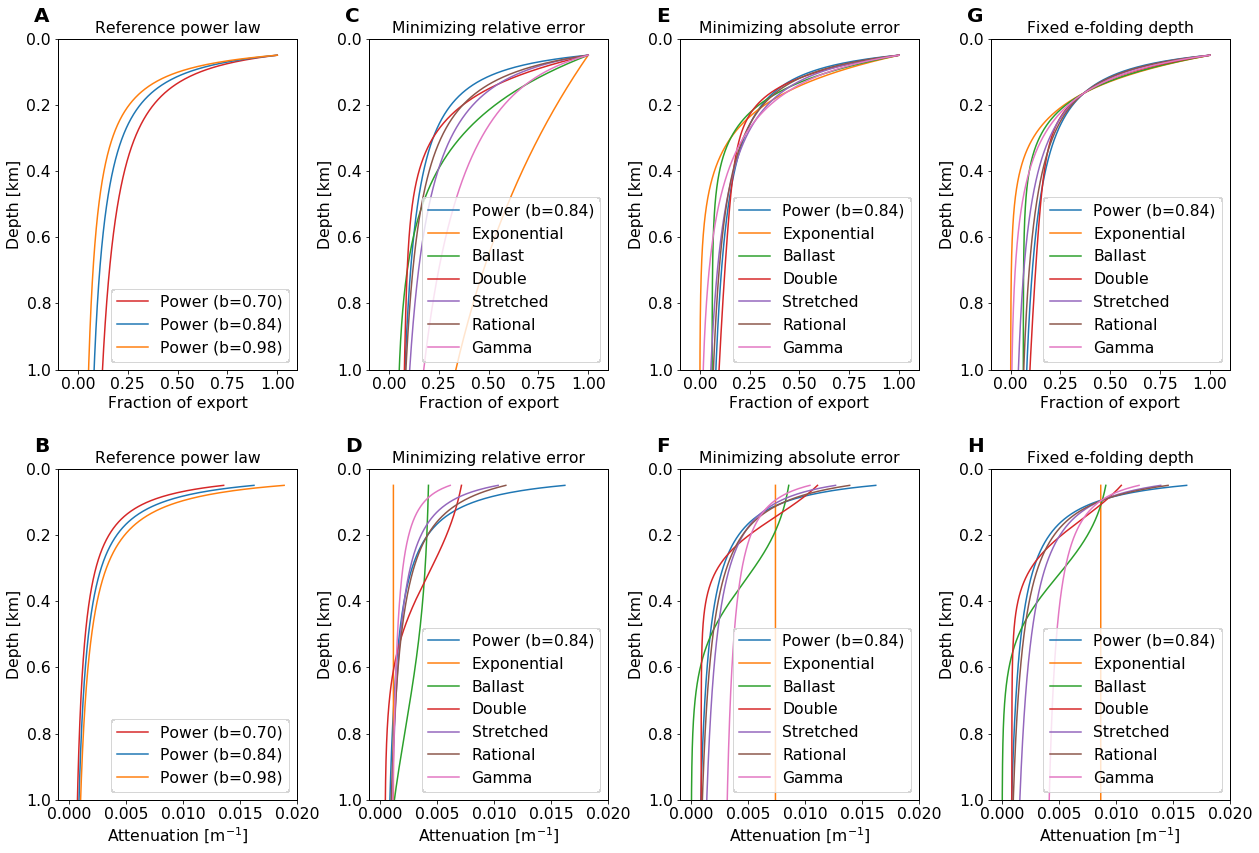

In [2]:
remin_shapes={}

remin_shapes['depth']=-np.linspace(50,5200,2576)
z=remin_shapes['depth']/-50
'''
#minimizing relative error:
remin_shapes['fmar07']  = (z)**-0.7                                                            # KREMIN = 0.7   , 0.    , 0.     , 0.   , 
remin_shapes['fmar08']  = (z)**-0.8                                                            # KREMIN = 0.8.  , 0.    , 0.     , 0.   , 
remin_shapes['fmar09']  = (z)**-0.9                                                            # KREMIN = 0.9.  , 0.    , 0.     , 0.   , 
remin_shapes['fmar10']  = (z)**-1.0                                                            # KREMIN = 1.0.  , 0.    , 0.     , 0.   , 
remin_shapes['frelexp'] = 1.064*np.exp(-z/(811.4/50))                                          # KREMIN = 1.064 , 16.228, 0.     , 0.   ,
remin_shapes['frelbal'] = 1.224*(0.02423 + np.exp(-z/(215.1/50)))                              # KREMIN = 1.224 , 4.302 , 0.02423, 0.   ,
remin_shapes['frelrat'] = (71.25/50)/(z+(21.25/50))                                            # KREMIN = 1.425 , 0.425 , 0.     , 0.   ,
remin_shapes['frelstr'] = 6683*np.exp(-6.270*(50**0.08683)*z**0.08683)                         # KREMIN = 6683  , 8.8062,-0.08683, 0.   ,
# Use exponential integral rather than gamma function
remin_shapes['frelgam'] = 0.3341*sp.expn    (1,z/(1727/50))                                    # KREMIN = 0.3341, 34.54 , 0.     , 0.   ,

#minimizing absolute error:
remin_shapes['fabsexp'] = 1.518*np.exp(-z/(119.7/50))                                          # KREMIN = 1.518 , 2.394 , 0.     , 0.   ,
remin_shapes['fabsbal'] = 1.559*(0.03394 + np.exp(-z/(100.3/50)))                              # KREMIN = 1.559 , 2.006 , 0.03394, 0.   ,
remin_shapes['fabsrat'] = (61.14/50)/(z+(11.14/50))                                            # KREMIN = 1.2228, 0.2228, 0.     , 0.   ,
remin_shapes['fabsstr'] = 7387*np.exp(-6.361*(50**0.08685)*z**0.08685)                         # KREMIN = 7387  , 8.9347,-0.08685, 0.   ,
# Use exponential integral rather than gamma function
remin_shapes['fabsgam'] = 0.6700*sp.expn    (1,z/(344.4/50))                                   # KREMIN = 0.6700, 6.888 , 0.     , 0.   ,

# Setting the e-folding lengthscale to be the same (152m)
remin_shapes['fefdexp'] = 1.628*np.exp(-z/(102/50))
remin_shapes['fefdbal'] = 1.625*(0.0337 + np.exp(-z/(92.31/50)))
remin_shapes['fefdrat'] = (59.36/50)/(z+(9.361/50))
remin_shapes['fefdstr'] = 1045*np.exp(-4.333*(50**0.1208)*z**0.1208)                           #  KREMIN(1:4)=1045, 6.9506, -0.1208, 0.,
remin_shapes['fefdstr2']= 1045*np.exp(-6.9506*np.exp(0.1208*np.log(z)))
# Use exponential integral rather than gamma function
remin_shapes['fefdgam'] = 0.812*sp.expn    (1,z/(252.7/50)) 
'''

# Read coefficients in from the MATLAB script that created them by curvefitting
coeffs=pd.read_csv('export_profile_coefficients.csv',
                   names=['pmarref','pabsexp','pabsbal','pabsdbl','pabsstr','pabsrat','pabsgam',
                                    'prelexp','prelbal','preldbl','prelstr','prelrat','prelgam',
                                    'pefdexp','pefdbal','pefddbl','pefdstr','pefdrat','pefdgam'])
remin_shapes['fmar07']  = (z)**-0.70                                                                              # KREMIN = 0.7    , 0.    , 0.     , 0.   , 
remin_shapes['fmar08']  = (z)**-0.84                                                                             # KREMIN = 0.84.  , 0.    , 0.     , 0.   , 
#remin_shapes['fmar09']  = (z)**-0.9                                                                              # KREMIN = 0.9.   , 0.    , 0.     , 0.   , 
remin_shapes['fmar10']  = (z)**-0.98                                                                             # KREMIN = 0.98.  , 0.    , 0.     , 0.   , 

#minimizing relative error:
remin_shapes['frelexp'] = coeffs['prelexp'][0]*np.exp(-z/(coeffs['prelexp'][1]/50))                              # KREMIN = 1.064 , 16.228, 0.     , 0.   ,
remin_shapes['frelbal'] = coeffs['prelbal'][0]*(coeffs['prelbal'][2] + np.exp(-z/(coeffs['prelbal'][1]/50)))     # KREMIN = 1.224 , 4.302 , 0.02423, 0.   ,
remin_shapes['frelrat'] =(coeffs['prelrat'][0]/50)/(z+coeffs['prelrat'][1]/50)                                   # KREMIN = 1.425 , 0.425 , 0.     , 0.   ,
remin_shapes['freldbl'] = coeffs['preldbl'][0]*np.exp(-z/(coeffs['preldbl'][1]/50)) + \
                          coeffs['preldbl'][0]*coeffs['preldbl'][2]*np.exp(-z/(np.abs(coeffs['preldbl'][3])/50)) # KREMIN = 1.374 , 2.3820, 0.02954, 46.84,
# In the model, we absorb c=50**coeffs['prelstr'][1] and take z^coeffs['prelstr'][1] = exp(coeffs['prelstr'][1]*log(z))
#                                          frelstr = coeffs['pabsstr'][0]*np.exp(-c*np.exp(coeffs['prelstr'][1]*log(z/z0)))
remin_shapes['frelstr'] = coeffs['prelstr'][0]*np.exp(-(50**coeffs['prelstr'][1])*z**coeffs['prelstr'][1])       # KREMIN = 6683  , 8.8062,-0.08683, 0.   ,
remin_shapes['frelgam'] = coeffs['prelgam'][0]*sp.expn(1,z/(coeffs['prelgam'][1]/50))                            # KREMIN = 0.3341, 34.54 , 0.     , 0.   ,

#minimizing absolute error:
remin_shapes['fabsexp'] = coeffs['pabsexp'][0]*np.exp(-z/(coeffs['pabsexp'][1]/50))                              # KREMIN = 1.064 , 16.228, 0.     , 0.   ,
remin_shapes['fabsbal'] = coeffs['pabsbal'][0]*(coeffs['pabsbal'][2] + np.exp(-z/(coeffs['pabsbal'][1]/50)))     # KREMIN = 1.224 , 4.302 , 0.02423, 0.   ,
remin_shapes['fabsrat'] =(coeffs['pabsrat'][0]/50)/(z+coeffs['pabsrat'][1]/50)                                   # KREMIN = 1.425 , 0.425 , 0.     , 0.   ,
remin_shapes['fabsdbl'] = coeffs['pabsdbl'][0]*np.exp(-z/(coeffs['pabsdbl'][1]/50)) + \
                          coeffs['pabsdbl'][0]*coeffs['pabsdbl'][2]*np.exp(-z/(np.abs(coeffs['pabsdbl'][3])/50)) # KREMIN = 1.374 , 2.3820, 0.02954, 46.84,
remin_shapes['fabsstr'] = coeffs['pabsstr'][0]*np.exp(-(50**coeffs['pabsstr'][1])*z**coeffs['pabsstr'][1])       # KREMIN = 6683  , 8.8062,-0.08683, 0.   ,
remin_shapes['fabsgam'] = coeffs['pabsgam'][0]*sp.expn(1,z/(coeffs['pabsgam'][1]/50))                            # KREMIN = 0.6700, 6.888 , 0.     , 0.   ,

# Setting the e-folding lengthscale to be the same (164)
remin_shapes['fefdexp'] = coeffs['pefdexp'][0]*np.exp(-z/(coeffs['pefdexp'][1]/50))                              # KREMIN = 1.064 , 16.228, 0.     , 0.   ,
remin_shapes['fefdbal'] = coeffs['pefdbal'][0]*(coeffs['pefdbal'][2] + np.exp(-z/(coeffs['pefdbal'][1]/50)))     # KREMIN = 1.224 , 4.302 , 0.02423, 0.   ,
remin_shapes['fefdrat'] =(coeffs['pefdrat'][0]/50)/(z+coeffs['pefdrat'][1]/50)                                   # KREMIN = 1.425 , 0.425 , 0.     , 0.   ,
remin_shapes['fefddbl'] = coeffs['pefddbl'][0]*np.exp(-z/(coeffs['pefddbl'][1]/50)) + \
                          coeffs['pefddbl'][0]*coeffs['pefddbl'][2]*np.exp(-z/(np.abs(coeffs['pefddbl'][3])/50)) # KREMIN = 1.374 , 2.3820, 0.02954, 46.84,
remin_shapes['fefdstr'] = coeffs['pefdstr'][0]*np.exp(-(50**coeffs['pefdstr'][1])*z**coeffs['pefdstr'][1])       # KREMIN = 6683  , 8.8062,-0.08683, 0.   ,
remin_shapes['fefdgam'] = coeffs['pefdgam'][0]*sp.expn(1,z/(coeffs['pefdgam'][1]/50))                            # KREMIN = 0.6700, 6.888 , 0.     , 0.   ,

expt=["rel","abs","efd"]
expn=["Minimizing relative error",
      "Minimizing absolute error",
      "Fixed e-folding depth"]
prof=["exp","bal","dbl","str","rat","gam"]
names=["Exponential",
       "Ballast",
       "Double",
       "Stretched",
       "Rational",
       "Gamma"]

plt.rcParams['xtick.labelsize'] ='large'
plt.rcParams['ytick.labelsize'] ='large'
plt.rcParams['axes.labelsize' ] ='large'
plt.rcParams['legend.fontsize'] ='large'
plt.rcParams['figure.titlesize']='large'
plt.rcParams['font.size']       ='13'

fig0, f0ax = plt.subplots(figsize=(21, 14),ncols=4,nrows=2)
fig0.patch.set_facecolor('None')

f0ax[0,0].plot(remin_shapes['fmar07'],np.abs(remin_shapes['depth']/1000),label="Power (b=0.70)",color='#d62728')
f0ax[0,0].plot(remin_shapes['fmar08'],np.abs(remin_shapes['depth']/1000),label="Power (b=0.84)",color='#1f77b4') #'#2ca02c')
#f0ax[0,0].plot(remin_shapes['fmar09'],np.abs(remin_shapes['depth']/1000),label="Power (b=0.90)",color='#1f77b4')
f0ax[0,0].plot(remin_shapes['fmar10'],np.abs(remin_shapes['depth']/1000),label="Power (b=0.98)",color='#ff7f0e')
f0ax[0,0].legend(loc="lower right")
f0ax[0,0].set(title='Reference power law',xlim=(-0.1,1.1),xlabel='Fraction of export',
                                          ylim=(1,0)   ,ylabel='Depth [km]')

for jj in np.arange(len(expt)):
    f0ax[0,jj+1].plot(remin_shapes['fmar08'],np.abs(remin_shapes['depth']/1000),label="Power (b=0.84)")
    for ii in np.arange(len(prof)):
        f0ax[0,jj+1].plot(remin_shapes['f'+expt[jj]+prof[ii]],np.abs(remin_shapes['depth']/1000),label=names[ii])
    f0ax[0,jj+1].legend(loc="lower right")
    f0ax[0,jj+1].set(title=expn[jj],xlim=(-0.1,1.1),xlabel='Fraction of export',ylim=(1,0)   ,ylabel='Depth [km]')

# Attenuation is (1/f)(df/dz)
f0ax[1,0].plot((1/remin_shapes['fmar07'][:-1])*(np.diff(remin_shapes['fmar07'])/np.diff(remin_shapes['depth'])),\
               np.abs(remin_shapes['depth'][:-1]/1000),label="Power (b=0.70)",color='#d62728')
f0ax[1,0].plot((1/remin_shapes['fmar08'][:-1])*(np.diff(remin_shapes['fmar08'])/np.diff(remin_shapes['depth'])),\
               np.abs(remin_shapes['depth'][:-1]/1000),label="Power (b=0.84)",color='#1f77b4')
#f0ax[1,0].plot((1/remin_shapes['fmar09'][:-1])*(np.diff(remin_shapes['fmar09'])/np.diff(remin_shapes['depth'])),\
#               np.abs(remin_shapes['depth'][:-1]/1000),label="Power (b=0.90)",color='#2ca02c')
f0ax[1,0].plot((1/remin_shapes['fmar10'][:-1])*(np.diff(remin_shapes['fmar10'])/np.diff(remin_shapes['depth'])),\
               np.abs(remin_shapes['depth'][:-1]/1000),label="Power (b=0.98)",color='#ff7f0e')
f0ax[1,0].legend(loc="lower right")
f0ax[1,0].set(title='Reference power law',xlim=(-0.001,0.02),xticks=np.arange(0,0.025,0.005),xlabel='Attenuation [m$^{-1}$]',
                                          ylim=(1,0),ylabel='Depth [km]')

for jj in np.arange(len(expt)):
    f0ax[1,jj+1].plot((1/remin_shapes['fmar08'][:-1])*(np.diff(remin_shapes['fmar08'])/np.diff(remin_shapes['depth'])),\
                   np.abs(remin_shapes['depth'][:-1]/1000),label="Power (b=0.84)")
    for ii in np.arange(len(prof)):
        remin_shape=remin_shapes['f'+expt[jj]+prof[ii]]
        f0ax[1,jj+1].plot((1/remin_shape[:-1])*(np.diff(remin_shape)/np.diff(remin_shapes['depth'])),\
                       np.abs(remin_shapes['depth'][:-1]/1000),label=names[ii])
    f0ax[1,jj+1].set_title(expn[jj])
    f0ax[1,jj+1].legend(loc="lower right")
    f0ax[1,jj+1].set(title=expn[jj],xlim=(-0.001,0.02),xticks=np.arange(0,0.025,0.005),xlabel='Attenuation [m$^{-1}$]',\
                                    ylim=(1,0),ylabel='Depth [km]')

# Can adjust the subplot size
plt.subplots_adjust(wspace=0.3,hspace=0.3)

# add subplot labels (a,b,c,d, etc)
label_axes(f0ax,label_columns=True)

plt.show()  
#fig0.savefig('/Users/'+gp.getuser()+'/Dropbox/work/Paper_Drafts/exports/Figures/export_profiles.pdf',facecolor=fig0.get_facecolor(), edgecolor='none',bbox_inches='tight')

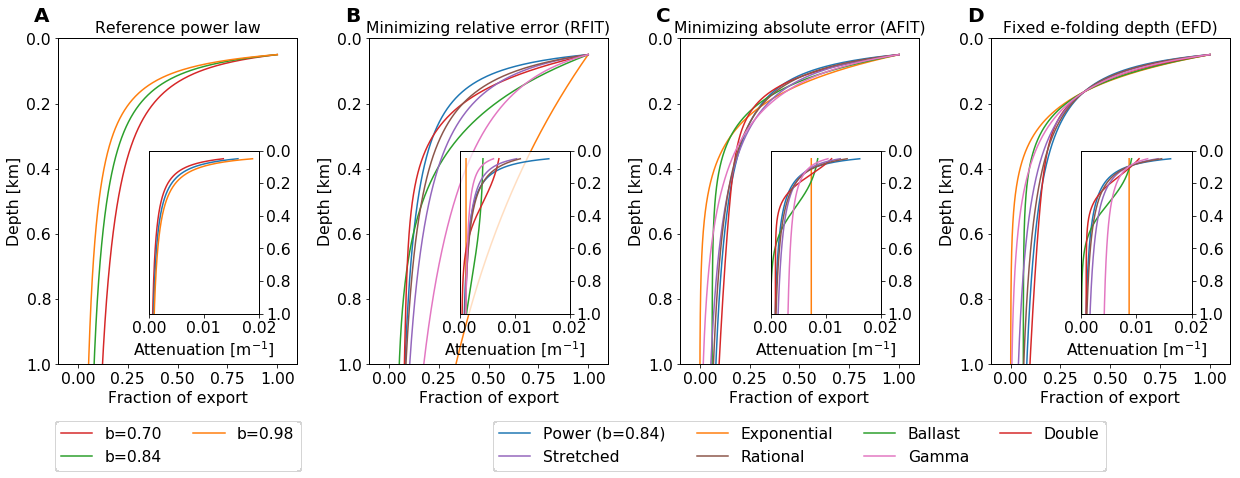

In [3]:
fig1, f1ax = plt.subplots(figsize=(21, 6),ncols=4)
fig1.patch.set_facecolor('None')

f1ax[0].plot(remin_shapes['fmar07'],np.abs(remin_shapes['depth']/1000),label="b=0.70",color='#d62728')
f1ax[0].plot(remin_shapes['fmar08'],np.abs(remin_shapes['depth']/1000),label="b=0.84",color='#2ca02c')
#f1ax[0].plot(remin_shapes['fmar09'],np.abs(remin_shapes['depth']/1000),label="b=0.9",color='#1f77b4')
f1ax[0].plot(remin_shapes['fmar10'],np.abs(remin_shapes['depth']/1000),label="b=0.98",color='#ff7f0e')
f1ax[0].legend(ncol=2,loc="lower center",bbox_to_anchor=(0.5,-0.35))
f1ax[0].set(title='Reference power law',xlim=(-0.1,1.1),xlabel='Fraction of export',
                                          ylim=(1,0)   ,ylabel='Depth [km]')

for jj in np.arange(len(expt)):
    f1ax[jj+1].plot(remin_shapes['fmar08'],np.abs(remin_shapes['depth']/1000),label="Power (b=0.84)")
    for ii in np.arange(len(prof)):
        f1ax[jj+1].plot(remin_shapes['f'+expt[jj]+prof[ii]],np.abs(remin_shapes['depth']/1000),label=names[ii])
    if jj==2:
        handles, labels = f1ax[jj+1].get_legend_handles_labels()
        f1ax[jj].legend(flip(handles, 4), flip(labels, 4),ncol=4,loc="lower center",bbox_to_anchor=(0.5,-0.35))
    f1ax[jj+1].set(xlim=(-0.1,1.1),xlabel='Fraction of export',ylim=(1,0),ylabel='Depth [km]')

f1ax[1].set_title('Minimizing relative error (RFIT)')
f1ax[2].set_title('Minimizing absolute error (AFIT)')
f1ax[3].set_title('Fixed e-folding depth (EFD)')

# Attenuation is (1/f)(df/dz)
f1axins=f1ax.copy()
for kk in np.arange(len(f1ax)):
    f1axins[kk] = inset_axes(f1ax[kk], width="50%", height="40%", loc=4, borderpad=2, 
                             bbox_to_anchor=(0.05, 0.06, 0.92, 1.25),bbox_transform=f1ax[kk].transAxes)

f1axins[0].plot((1/remin_shapes['fmar07'][:-1])*(np.diff(remin_shapes['fmar07'])/np.diff(remin_shapes['depth'])),
                np.abs(remin_shapes['depth'][:-1]/1000),label="Power (b=0.7)",color='#d62728')
f1axins[0].plot((1/remin_shapes['fmar08'][:-1])*(np.diff(remin_shapes['fmar08'])/np.diff(remin_shapes['depth'])),
                np.abs(remin_shapes['depth'][:-1]/1000),label="Power (b=0.84)",color='#1f77b4')
#f1axins[0].plot((1/remin_shapes['fmar09'][:-1])*(np.diff(remin_shapes['fmar09'])/np.diff(remin_shapes['depth'])),
#                np.abs(remin_shapes['depth'][:-1]/1000),label="Power (b=0.9)",color='#1f77b4') #'#2ca02c'
f1axins[0].plot((1/remin_shapes['fmar10'][:-1])*(np.diff(remin_shapes['fmar10'])/np.diff(remin_shapes['depth'])),
                np.abs(remin_shapes['depth'][:-1]/1000),label="Power (b=0.98)",color='#ff7f0e')
f1axins[0].set(xlim=(0,0.02),xticks=np.arange(0,0.03,0.01),xlabel='Attenuation [m$^{-1}$]',
               ylim=(1,0),yticks=np.arange(0,1.2,0.2))
f1axins[0].yaxis.set_ticks_position("right")
f1axins[0].patch.set_alpha(0.75)

for jj in np.arange(len(expt)):
    f1axins[jj+1].plot((1/remin_shapes['fmar08'][:-1])*(np.diff(remin_shapes['fmar08'])/np.diff(remin_shapes['depth'])),
               np.abs(remin_shapes['depth'][:-1]/1000),label="Power (b=0.84)")
    for ii in np.arange(len(prof)):
        remin_shape=remin_shapes['f'+expt[jj]+prof[ii]]
        f1axins[jj+1].plot((1/remin_shape[:-1])*(np.diff(remin_shape)/np.diff(remin_shapes['depth'])),
                   np.abs(remin_shapes['depth'][:-1]/1000),label=names[ii])
    f1axins[jj+1].yaxis.set_ticks_position("right")
    f1axins[jj+1].set(xlim=(0.0,0.02),xticks=np.arange(0,0.03,0.01),xlabel='Attenuation [m$^{-1}$]',
                      ylim=(1,0),yticks=np.arange(0,1.2,0.2))
    f1axins[jj+1].patch.set_alpha(0.75)

# Can adjust the subplot size
plt.subplots_adjust(wspace=0.3)

# add subplot labels (a,b,c,d, etc)
label_axes(f1ax,label_columns=True)

plt.show()  
#fig1.savefig('/Users/'+gp.getuser()+'/Dropbox/work/Paper_Drafts/exports/Figures/export_profiles2.pdf',facecolor=fig1.get_facecolor(), edgecolor='none',bbox_inches='tight')

## Goodness of fit is demonstrated by the Standard Error of Regression (SER), also calculated by the script that generated the coefficients. 

SER is the sum of the square residuals, divided by the difference between the number of points and the number of fitted parameters. 

$R^2$ does not make sense for a non-linear regression!

In [4]:
ser = np.zeros((len(prof),len(expt)))

for jj in np.arange(len(expt)):
    for ii in np.arange(len(prof)):
        ser[ii,jj]=coeffs['p'+expt[jj]+prof[ii]].tail(1)

pd_ser = pd.DataFrame(ser, index=names,columns=["Relative","Absolute","E-folding"])

print("Standard error of regression:")
print(np.round(pd_ser,4))

Standard error of regression:
             Relative  Absolute  E-folding
Exponential    1.1066    0.0701     0.0700
Ballast        0.3838    0.0453     0.0440
Double         0.1559    0.0175     0.0175
Stretched      0.2499    0.0260     0.0314
Rational       0.1174    0.0112     0.0119
Gamma          0.6272    0.0499     0.0543


## Load in the ensemble of runs

In [5]:
molperm3_2_umolperkg=1e6/1024.5
# We are considering P, so RNP=1 (otherwise convert P to N with RNP=16)
R_np=1

# Establish a path name and use "glob" to process wild card filenames
# Find experiments abs, rel, efd (e-folding depth), and martin
paths  = gb.glob('/Volumes/Atlantis/exports/f_abs???/f_*_global/')\
        +gb.glob('/Volumes/Atlantis/exports/f_rel???/f_*_global/')\
        +gb.glob('/Volumes/Atlantis/exports/f_efd???/f_*_global/')\
        +gb.glob('/Volumes/Atlantis/exports/f_mar????/f_*_global/')

icntrl=19

# just open any old one
grid_data,xgrid=mitgcm_tools.loadgrid(gb.glob(paths[0]+'grid.glob.nc')[0])
grid_data=grid_data.transpose('XC','XG','YC','YG','ZC','ZG','ZL','ZR')

nx=grid_data.dims['XC']
ny=grid_data.dims['YC']
nz=grid_data.dims['ZC']

lon=grid_data.XC
lat=grid_data.YC

zc=np.abs(grid_data.RC)/1000 # in km
zf=np.abs(grid_data.RF)/1000 # in km

# Reshape axes to have the same dimensions
vol=(grid_data.rA*grid_data.drF).where(grid_data.HFacC>grid_data.HFacC.min())

grid_data.close()

read_paths=paths

dic  = xr.Dataset()
alk  = xr.Dataset()
po4  = xr.Dataset()
oxy  = xr.Dataset()
cpre = xr.Dataset()
apre = xr.Dataset()
ppre = xr.Dataset()
opre = xr.Dataset()
creg = xr.Dataset()
co2_flux   = xr.Dataset()
export_flux= xr.Dataset()
mld        = xr.Dataset()
expmld     = xr.Dataset()

bioprod  = np.ones((len(read_paths)+1,1))*0
pstar    = np.ones((len(read_paths)+1,1))*0
atmpco2  = np.ones((len(read_paths)+1,1))*0
intexp   = np.ones((len(read_paths)+1,1))*0
intex1k  = np.ones((len(read_paths)+1,1))*0
intex2k  = np.ones((len(read_paths)+1,1))*0
intex3k  = np.ones((len(read_paths)+1,1))*0
intexpmld= np.ones((len(read_paths)+1,1))*0
intdic   = np.ones((len(read_paths)+1,1))*0
intcreg  = np.ones((len(read_paths)+1,1))*0

# First, read in a monthly climatology of MITgcm MLD - these experiments all have the same circulation
model_run=mitgcm_tools.open_ncfile("/Users/jml1/Dropbox_Work/cfluxes_matlab/model_kpp/surfDiag.*.glob.nc",
                                            strange_axes={'Zmd000001':'ZC','Zd000001':'ZL'},grid=grid_data)
mld['mld']    = model_run.MXLDEPTH
mld['maxmld'] = model_run.MXLDEPTH.max (dim="T")
mld['meanmld']= model_run.MXLDEPTH.mean(dim="T")
mld['minmld'] = model_run.MXLDEPTH.min (dim="T")
model_run.close()

model_run=mitgcm_tools.open_ncfile("/Users/jml1/Dropbox_Work/cfluxes_matlab/model_kpp/oceDiag.*.glob.nc",
                                            strange_axes={'Zmd000015':'ZC','Zld000015':'ZL'},grid=grid_data)
oceDiag = model_run.copy()
model_run.close()

# Read all experiments
for i in range(len(read_paths)):
    if read_paths[i]==" ":
        continue        
    print(read_paths[i])
    
    name=read_paths[i].split('/')[-3]
    
    try: 
        data_parms=mitgcm_tools.getparm(read_paths[i]+'../input/data') 
    except FileNotFoundError:
        try: 
            data_parms=mitgcm_tools.getparm(read_paths[i]+'../input/data.orig')
        except FileNotFoundError:
            data_parms=mitgcm_tools.getparm(read_paths[i]+'../input/data.001')

    data_pkg=mitgcm_tools.getparm(read_paths[i]+'../input/data.pkg') 
    data_dic=mitgcm_tools.getparm(read_paths[i]+'../input/data.dic') 

    model_run=mitgcm_tools.open_ncfile(gb.glob(read_paths[i]+'tave.*.glob.nc')[0])
    
    if i==0:
        grid_data['T']=model_run.coords["T"]
        grid_data['Tyr']=model_run.coords["T"]/(86400*360)
        grid_data['iter']=model_run.iter
    
    theta=model_run.Ttave.isel(T=-1)
    salt=model_run.Stave.isel(T=-1)
    model_run.close()

    model_run=mitgcm_tools.open_ncfile(gb.glob(read_paths[i]+'surfDiag.*.glob.nc')[0],
                                         strange_axes={'Zmd000001':'ZC','Zd000001':'ZL'},grid=grid_data)
    mld[name]=model_run.MXLDEPTH.isel(T=-1)
    model_run.close()
    
    model_run=mitgcm_tools.open_ncfile(gb.glob(read_paths[i]+'ptr_tave.*.glob.nc')[0])
    nt   = model_run.dims['T']

    dic[name]=model_run.dic.isel(T=-1)*molperm3_2_umolperkg # in umol/kg
    alk[name]=model_run.alk.isel(T=-1)*molperm3_2_umolperkg # in umol/kg
    po4[name]=model_run.po4.isel(T=-1)*molperm3_2_umolperkg # in umol/kg
    oxy[name]=model_run.o2 .isel(T=-1)*molperm3_2_umolperkg # in umol/kg

    cpre[name]=model_run.cpre.isel(T=-1)*molperm3_2_umolperkg # in umol/kg
    apre[name]=model_run.apre.isel(T=-1)*molperm3_2_umolperkg # in umol/kg
    ppre[name]=model_run.ppre.isel(T=-1)*molperm3_2_umolperkg # in umol/kg
    opre[name]=model_run.opre.isel(T=-1)*molperm3_2_umolperkg # in umol/kg

    creg[name]=(model_run.dic.isel(T=-1)-model_run.cpre.isel(T=-1))*molperm3_2_umolperkg # in umol/kg
    
    intdic [i] = (grid_data.cvol*grid_data.cmask*model_run.dic.isel(T=-1))\
                    .sum(("XC","YC","ZC"))*12e-15 # in PgC
    intcreg[i] = (grid_data.cvol*grid_data.cmask*(model_run.dic.isel(T=-1)-model_run.cpre.isel(T=-1)))\
                    .sum(("XC","YC","ZC"))*12e-15 # in PgC

    model_run.close()

    pstar[i]=np.mean((po4[read_paths[i].split('/')[-3]]-ppre[read_paths[i].split('/')[-3]])
                     /po4[read_paths[i].split('/')[-3]]) # fraction

    model_run=mitgcm_tools.open_ncfile(gb.glob(read_paths[i]+'dicDiag.*.glob.nc')[0],
                                         strange_axes={'Zmd000015':'ZC','Zld000015':'ZL'},grid=grid_data)
    # Export flux is mol P/m2/s
    export_flux[name]=model_run.CEXPFLX.isel(T=-1)*117*(360*86400) # in mol C/m2/yr
    intexp [i] = (grid_data.rA*grid_data.cmask*model_run.CEXPFLX.isel(T=-1))\
            .sum(("XC","YC","ZC"))*(360*86400)*117*12e-15 # in PgC/yr 
    intex1k[i] = (grid_data.rA*grid_data.cmask.sel(ZC=-1000,method='nearest')
                *model_run.CEXPFLX.isel(T=-1).sel(ZC=-1000,method='nearest'))\
            .sum(("XC","YC"))*(360*86400)*117*12e-15 # in PgC/yr     
    intex2k[i] = (grid_data.rA*grid_data.cmask.sel(ZC=-2000,method='nearest')
                *model_run.CEXPFLX.isel(T=-1).sel(ZC=-2000,method='nearest'))\
            .sum(("XC","YC"))*(360*86400)*117*12e-15 # in PgC/yr
    intex3k[i] = (grid_data.rA*grid_data.cmask.sel(ZC=-3000,method='nearest')
                *model_run.CEXPFLX.isel(T=-1).sel(ZC=-3000,method='nearest'))\
            .sum(("XC","YC"))*(360*86400)*117*12e-15 # in PgC/yr
    
    # Interpolate export fluxes on to mixed layer depth
    expmld[name]= model_run.CEXPFLX.isel(T=-1).sel(ZC=-mld['maxmld'],method='nearest')*1e6*117*(360*86400) # in umol C/m2/yr
    intexpmld[i]=(model_run.CEXPFLX.isel(T=-1).sel(ZC=-mld['maxmld'],method='nearest')*
                  grid_data.rA*grid_data.cmask.sel(ZC=-mld['maxmld'],method='nearest'))\
                    .sum(("XC","YC"))*(360*86400)*117*12e-15 # in PgC/yr  
    
    bioprod[i]= (grid_data.cvol*grid_data.cmask*model_run.DICBIOA.isel(T=-1))\
                    .sum(("XC","YC","ZC"))*(360*86400)*117*12e-15 # in PgC/yr
    model_run.close()
    
    model_run=mitgcm_tools.open_ncfile(gb.glob(read_paths[i]+'dic_surfDiag.*.glob.nc')[0],
                                         strange_axes={'Zmd000001':'ZC','Zd000001':'ZL'},grid=grid_data)
    co2_flux[name]=model_run.DICCFLX.isel(T=-1)*(360*86400) # in molC/m2/yr
    model_run.close()
    
    atm_box=mitgcm_tools.get_dicpco2(data_parms,data_dic,grid_data,path=read_paths[i])
    atmpco2[i]=atm_box.pco2.isel(T=-1).load()*1e6


The axes: T could not be converted
Attributes could not be added for axes: T
Coordinates added for axes: ZC
Coordinates added for axes: ZC,ZL
The axes: T could not be converted
Attributes could not be added for axes: T
Coordinates added for axes: ZC
Coordinates added for axes: ZC,ZL
/Volumes/Atlantis/exports/f_absbal/f_absbal_global/
The axes: T could not be converted
Attributes could not be added for axes: T
The axes: T could not be converted
Attributes could not be added for axes: T
Coordinates added for axes: ZC
Coordinates added for axes: ZC,ZL
The axes: T could not be converted
Attributes could not be added for axes: T
The axes: T could not be converted
Attributes could not be added for axes: T
Coordinates added for axes: ZC
The axes: T could not be converted
Attributes could not be added for axes: T
Coordinates added for axes: ZC
Coordinates added for axes: ZC,ZL
The axes: T could not be converted
Attributes could not be added for axes: T
Coordinates added for axes: ZC
Coordinate

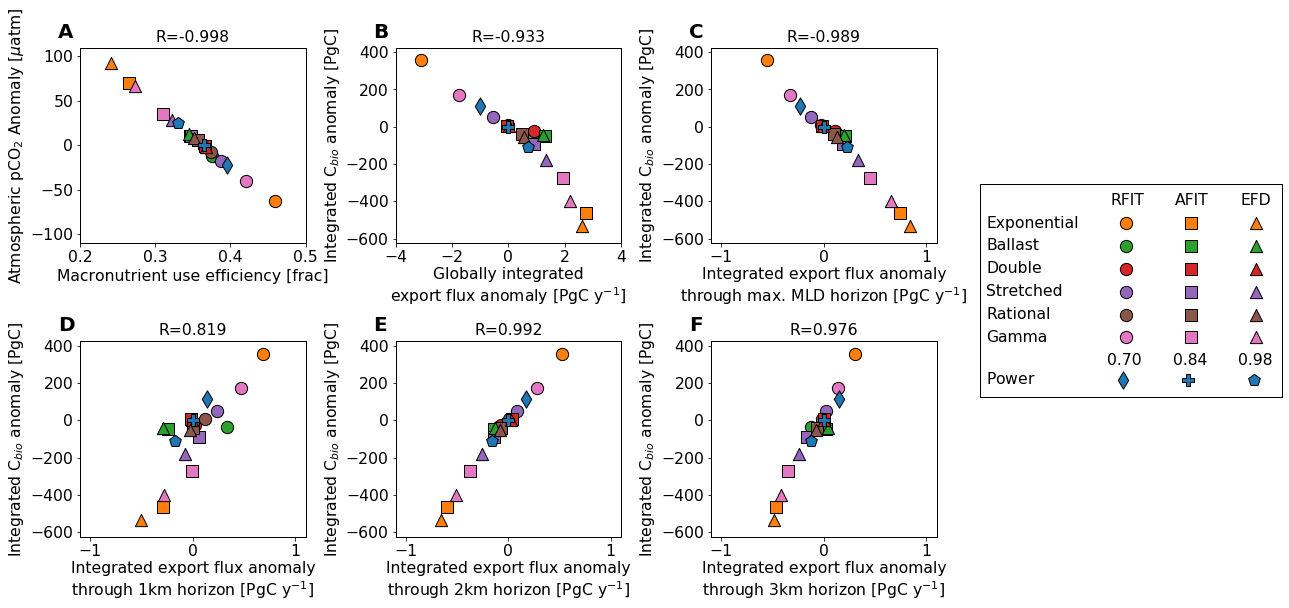

In [6]:
fig2a, f2aax = plt.subplots(figsize=(21, 9),ncols=4,nrows=2)
fig2a.patch.set_facecolor('None')

myorder= [8,6,7,11,10,9,2,0,1,5,4,3,14,12,13,17,16,15]
martid = [18,19,20]
marhdl = [None]*(len(martid)+1)

datmpco2=atmpco2 - atmpco2[icntrl]    
dcreg  = intcreg - intcreg[icntrl]
dexpint= intexp  - intexp[icntrl]
dexp1km= intex1k - intex1k[icntrl]
dexp2km= intex2k - intex2k[icntrl]
dexp3km= intex3k - intex3k[icntrl]
dexpmld= intexpmld - intexpmld[icntrl]

for i in myorder+martid:
    facecolor, edgecolor, marker, label, member = get_point_attributes(paths[i])
    f2aax[0,0].scatter(pstar[i],datmpco2[i],s=150,
                        label=label,facecolor=facecolor,edgecolor=edgecolor,marker=marker,zorder=1)

s_pstar, i_pstar, r_pstar, p_pstar, se_pstar = st.linregress(pstar[myorder+martid].flatten(),datmpco2[myorder+martid].flatten())
#rmse_pstar = rmse(datmpco2[myorder+martid].flatten(),s_pstar*pstar[myorder+martid].flatten()+i_pstar)

f2aax[0,0].set_title('R={0}'.format(np.round(r_pstar,3)))
f2aax[0,0].set_ylabel('Atmospheric pCO$_2$ Anomaly [$\mu$atm]')
f2aax[0,0].set_xlabel('Macronutrient use efficiency [frac]')  
f2aax[0,0].set_xlim(left=0.2,right=0.5)
f2aax[0,0].set_ylim(top=110,bottom=-110) 

for i in myorder+martid:
    facecolor, edgecolor, marker, label, member = get_point_attributes(paths[i])
    f2aax[0,1].scatter(dexpint[i],dcreg[i],s=150,
                        label=label,facecolor=facecolor,edgecolor=edgecolor,marker=marker,zorder=1)

s_expint, i_expint, r_expint, p_expint, se_expint = st.linregress(dexpint[myorder+martid].flatten(),dcreg[myorder+martid].flatten())
#rmse_expint = rmse(dcreg[myorder+martid].flatten(),s_expint*dexpint[myorder+martid].flatten()+i_expint)

f2aax[0,1].set_title('R={0}'.format(np.round(r_expint,3)))
f2aax[0,1].set_ylabel('Integrated C$_{bio}$ anomaly [PgC]')
f2aax[0,1].set_xlabel('Globally integrated\nexport flux anomaly [PgC y$^{-1}$]')        
f2aax[0,1].set_xlim(left=-4,right=4)
f2aax[0,1].set_ylim(top=425,bottom=-625)   

for i in myorder:
    facecolor, edgecolor, marker, label, member = get_point_attributes(paths[i])
    f2aax[0,2].scatter(dexpmld[i],dcreg[i],s=150,
                        label=label,facecolor=facecolor,edgecolor=edgecolor,marker=marker,zorder=1)
    
first_legend = tablelegend(f2aax[0,2],ncol=3,loc="lower left",bbox_to_anchor=(0.715,0.4),bbox_transform=fig2a.transFigure,
            row_labels=["Exponential","Ballast","Double","Stretched","Rational","Gamma"], 
            col_labels=['RFIT', 'AFIT', 'EFD'], 
            title_label='',frameon=False)

f2aax[0,2].add_artist(first_legend)

# Now plot the martin curve experiments (including initial blank one) with different b-values and add the second legend
for i in range(len(martid)+1):
    if i==0:
        marhdl[i]=f2aax[0,2].scatter([],[],facecolor='w',edgecolor='w')
    else:
        facecolor, edgecolor, marker, label, member = get_point_attributes(paths[martid[i-1]])
        marhdl[i]=f2aax[0,2].scatter(dexpmld[martid[i-1]],dcreg[martid[i-1]],s=150,
                                  label=label,facecolor=facecolor,edgecolor=edgecolor,marker=marker,zorder=1)

second_legend = f2aax[0,2].legend(marhdl,["Power         $\,$","0.70\n\n","0.84\n\n","0.98\n\n"],
                                   ncol=4,loc="upper left",bbox_to_anchor=(0.715,0.43),bbox_transform=fig2a.transFigure,
                                   handletextpad=-2,frameon=False)

s_expmld, i_expmld, r_expmld, p_expmld, se_expmld = st.linregress(dexpmld[myorder+martid].flatten(),dcreg[myorder+martid].flatten())
#rmse_expmld = rmse(dcreg[myorder+martid].flatten(),s_expmld*dexpmld[myorder+martid].flatten()+i_expmld)

f2aax[0,2].set_title('R={0}'.format(np.round(r_expmld,3)))
f2aax[0,2].set_ylabel('Integrated C$_{bio}$ anomaly [PgC]')
f2aax[0,2].set_xlabel('Integrated export flux anomaly\nthrough max. MLD horizon [PgC y$^{-1}$]')    
f2aax[0,2].set_xlim(left=-1.1,right=1.1)
f2aax[0,2].set_ylim(top=425,bottom=-625)    

f2aax[0,3].axes.get_xaxis().set_visible(False)
f2aax[0,3].get_yaxis().set_visible(False)
f2aax[0,3].set_facecolor((1,1,1,0))
f2aax[0,3].set_axis_off()

for i in myorder+martid:
    facecolor, edgecolor, marker, label, member = get_point_attributes(paths[i])
    f2aax[1,0].scatter(dexp1km[i],dcreg[i],s=150,
                        label=label,facecolor=facecolor,edgecolor=edgecolor,marker=marker,zorder=1)

s_exp1km, i_exp1km, r_exp1km, p_exp1km, se_exp1km = st.linregress(dexp1km[myorder+martid].flatten(),dcreg[myorder+martid].flatten())
#rmse_exp1km = rmse(dcreg[myorder+martid].flatten(),s_exp1km*dexp1km[myorder+martid].flatten()+i_exp1km)

f2aax[1,0].set_title('R={0}'.format(np.round(r_exp1km,3)))
f2aax[1,0].set_ylabel('Integrated C$_{bio}$ anomaly [PgC]')
f2aax[1,0].set_xlabel('Integrated export flux anomaly\nthrough 1km horizon [PgC y$^{-1}$]')    
f2aax[1,0].set_xlim(left=-1.1,right=1.1)
f2aax[1,0].set_ylim(top=425,bottom=-625)    

for i in myorder+martid:
    facecolor, edgecolor, marker, label, member = get_point_attributes(paths[i])
    f2aax[1,1].scatter(dexp2km[i],dcreg[i],s=150,
                        label=label,facecolor=facecolor,edgecolor=edgecolor,marker=marker,zorder=1)

s_exp2km, i_exp2km, r_exp2km, p_exp2km, se_exp2km = st.linregress(dexp2km[myorder+martid].flatten(),dcreg[myorder+martid].flatten())
#rmse_exp2km = rmse(dcreg[myorder+martid].flatten(),s_exp2km*dexp2km[myorder+martid].flatten()+i_exp2km)

f2aax[1,1].set_title('R={0}'.format(np.round(r_exp2km,3)))
f2aax[1,1].set_ylabel('Integrated C$_{bio}$ anomaly [PgC]')
f2aax[1,1].set_xlabel('Integrated export flux anomaly\nthrough 2km horizon [PgC y$^{-1}$]')    
f2aax[1,1].set_xlim(left=-1.1,right=1.1)
f2aax[1,1].set_ylim(top=425,bottom=-625)    

for i in myorder+martid:
    facecolor, edgecolor, marker, label, member = get_point_attributes(paths[i])
    f2aax[1,2].scatter(dexp3km[i],dcreg[i],s=150,
                        label=label,facecolor=facecolor,edgecolor=edgecolor,marker=marker,zorder=1)

s_exp3km, i_exp3km, r_exp3km, p_exp3km, se_exp3km = st.linregress(dexp3km[myorder+martid].flatten(),dcreg[myorder+martid].flatten())
#rmse_exp3km = rmse(dcreg[myorder+martid].flatten(),s_exp3km*dexp3km[myorder+martid].flatten()+i_exp3km)

f2aax[1,2].set_title('R={0}'.format(np.round(r_exp3km,3)))
f2aax[1,2].set_ylabel('Integrated C$_{bio}$ anomaly [PgC]')
f2aax[1,2].set_xlabel('Integrated export flux anomaly\nthrough 3km horizon [PgC y$^{-1}$]')    
f2aax[1,2].set_xlim(left=-1.1,right=1.1)
f2aax[1,2].set_ylim(top=425,bottom=-625)    

f2aax[1,3].axes.get_xaxis().set_visible(False)
f2aax[1,3].get_yaxis().set_visible(False)
f2aax[1,3].set_facecolor((1,1,1,0))
f2aax[1,3].set_axis_off()

# Add a frame to the composite legend
f2aax[1,3].add_patch(plt.Rectangle((0.72,0.34),0.2,0.33,transform=fig2a.transFigure,
                                 clip_on=False,fill=False,edgecolor='k',joinstyle="round",zorder=1))
label_axes(f2aax,ignore=[3,7])                   

plt.subplots_adjust(wspace=0.4,hspace=0.5)    
plt.show()
#fig2a.savefig('/Users/'+gp.getuser()+'/Dropbox/work/Paper_Drafts/exports/Figures/export_scatterplots.pdf',facecolor=fig2a.get_facecolor(), edgecolor='none',bbox_inches='tight')

In [7]:
myorder= [8,6,7,11,10,9,2,0,1,5,4,3,14,12,13,17,16,15]
martid = [18,19,20]
pd_biop_mar=pd.DataFrame(np.reshape(bioprod[martid]-bioprod[icntrl],(1,len(martid))).T, 
                     index=["b=0.70","b=0.84","b=0.98"],columns=["Power Law"])
pd_biop_exp=pd.DataFrame(np.reshape(bioprod[myorder]-bioprod[icntrl],(len(expt),len(prof))).T, 
                     index=names,columns=["Relative","Absolute","E-folding"])
print("Control biological production is {0} PgC/yr".format(np.round(bioprod[icntrl],3)[0]))
print("Biological production anomalies [PgC/y] for Power law...")
print(np.round(pd_biop_mar,3))
print("\n...and remineralization profile experiments:")
print(np.round(pd_biop_exp,3))
print("")

pd_pstar_mar=pd.DataFrame(np.reshape(pstar[martid],(1,len(martid))).T, 
                     index=["b=0.70","b=0.84","b=0.98"],columns=["Power Law"])
pd_pstar_exp=pd.DataFrame(np.reshape(pstar[myorder],(len(expt),len(prof))).T, 
                     index=names,columns=["Relative","Absolute","E-folding"])
print("Biological pump efficiency [%] for Power law...")
print(np.round(pd_pstar_mar,3))
print("\n...and remineralization profile experiments:")
print(np.round(pd_pstar_exp,3))
print("")

print("Control atmospheric pCO2 is {0} uatm".format(np.round(atmpco2[icntrl],3)[0]))
pd_pco2_mar=pd.DataFrame(np.reshape(datmpco2[martid],(1,len(martid))).T, 
                     index=["b=0.70","b=0.84","b=0.98"],columns=["Power Law"])
pd_pco2_exp=pd.DataFrame(np.reshape(datmpco2[myorder],(len(expt),len(prof))).T, 
                     index=names,columns=["Relative","Absolute","E-folding"])
print("Change in atmospheric pCO2 [uatm] for Power law...")
print(np.round(pd_pco2_mar,3))
print("\n...and remineralization profile experiments:")
print(np.round(pd_pco2_exp,3))
print("")
print("Median change in atmospheric pCO2 across all experiments is {0}±{1} uatm ".format(
        np.round(np.median(np.abs(datmpco2[:18])),2),
        np.round(st.median_abs_deviation(np.abs(datmpco2[:18]))[0],2)
     ))
print("")
print("Median change in atmospheric pCO2 for each group is RFIT:{0}±{4}, AFIT:{1}±{5}, and EFD:{2}±{6} uatm. The grand median is {3}±{7} uatm".format(
        np.round(np.median(np.abs(datmpco2[ 6:12])),2),
        np.round(np.median(np.abs(datmpco2[ 0:6 ])),2),
        np.round(np.median(np.abs(datmpco2[12:18])),2),
        np.round(np.median([
            np.median(np.abs(datmpco2[ 6:12])),
            np.median(np.abs(datmpco2[ 0:6 ])),
            np.median(np.abs(datmpco2[12:18]))
            ]),2),
        np.round(st.median_abs_deviation(np.abs(datmpco2[ 6:12]))[0],2),
        np.round(st.median_abs_deviation(np.abs(datmpco2[ 0:6 ]))[0],2),
        np.round(st.median_abs_deviation(np.abs(datmpco2[12:18]))[0],2),
        np.round(st.median_abs_deviation([
            np.median(np.abs(datmpco2[ 6:12])),
            np.median(np.abs(datmpco2[ 0:6 ])),
            np.median(np.abs(datmpco2[12:18]))
            ]),2)
            ))
print("")
print("Across High Dynamic Range (BAL, DBL, STR, RAT) experiments:")
print("Median change in atmospheric pCO2 across high dynamic range experiments is {0}±{1} uatm".format(
          np.round(np.median(np.abs([datmpco2[ 6:8 ],datmpco2[10:12],datmpco2[ 0:2 ],datmpco2[ 4:6 ],datmpco2[12:14],datmpco2[16:18]])),2),
          np.round(st.median_abs_deviation(np.abs([datmpco2[ 6:8 ],datmpco2[10:12],datmpco2[ 0:2 ],datmpco2[ 4:6 ],datmpco2[12:14],datmpco2[16:18]]))[0][0],2)
     ))
print("")
print("Median change in atmospheric pCO2 for each group is RFIT:{0}±{4}, AFIT:{1}±{5}, and EFD:{2}±{6} uatm. The grand median is {3}±{7} uatm".format(
        np.round(np.median(np.abs([datmpco2[ 6:8 ],datmpco2[10:12]])),2),
        np.round(np.median(np.abs([datmpco2[ 0:2 ],datmpco2[ 4:6 ]])),2),
        np.round(np.median(np.abs([datmpco2[12:14],datmpco2[16:18]])),2),
        np.round(np.median([
            np.median(np.abs([datmpco2[ 6:8 ],datmpco2[10:12]])),
            np.median(np.abs([datmpco2[ 0:2 ],datmpco2[ 4:6 ]])),
            np.median(np.abs([datmpco2[12:14],datmpco2[16:18]]))
            ]),2),
        np.round(st.median_abs_deviation(np.abs([datmpco2[ 6:8 ],datmpco2[10:12]]))[0][0],2),
        np.round(st.median_abs_deviation(np.abs([datmpco2[ 0:2 ],datmpco2[ 4:6 ]]))[0][0],2),
        np.round(st.median_abs_deviation(np.abs([datmpco2[12:14],datmpco2[16:18]]))[0][0],2),
        np.round(st.median_abs_deviation([
            np.median(np.abs([datmpco2[ 6:8 ],datmpco2[10:12]])),
            np.median(np.abs([datmpco2[ 0:2 ],datmpco2[ 4:6 ]])),
            np.median(np.abs([datmpco2[12:14],datmpco2[16:18]]))
            ]),2),
          ))
print("")
print("Maximum change in atmospheric pCO2 for each group is RFIT:{0}, AFIT:{1}, and EFD:{2} uatm. The grand median is {3}±{4} uatm".format(
        np.round(np.max(np.abs([datmpco2[ 6:8 ],datmpco2[10:12]])),2),
        np.round(np.max(np.abs([datmpco2[ 0:2 ],datmpco2[ 4:6 ]])),2),
        np.round(np.max(np.abs([datmpco2[12:14],datmpco2[16:18]])),2),
        np.round(np.median([
            np.max(np.abs([datmpco2[ 6:8 ],datmpco2[10:12]])),
            np.max(np.abs([datmpco2[ 0:2 ],datmpco2[ 4:6 ]])),
            np.max(np.abs([datmpco2[12:14],datmpco2[16:18]]))
            ]),2),
        np.round(st.median_abs_deviation([
            np.max(np.abs([datmpco2[ 6:8 ],datmpco2[10:12]])),
            np.max(np.abs([datmpco2[ 0:2 ],datmpco2[ 4:6 ]])),
            np.max(np.abs([datmpco2[12:14],datmpco2[16:18]]))
            ]),2),
          ))

Control biological production is 29.57 PgC/yr
Biological production anomalies [PgC/y] for Power law...
        Power Law
b=0.70     -5.231
b=0.84      0.000
b=0.98      5.175

...and remineralization profile experiments:
             Relative  Absolute  E-folding
Exponential   -17.388     7.866     11.011
Ballast        -5.218     2.549      3.108
Double         -1.099    -0.273     -0.553
Stretched      -5.272     1.226      4.483
Rational       -2.525     0.892      1.593
Gamma         -11.419     4.023      8.622

Biological pump efficiency [%] for Power law...
        Power Law
b=0.70      0.395
b=0.84      0.365
b=0.98      0.330

...and remineralization profile experiments:
             Relative  Absolute  E-folding
Exponential     0.459     0.264      0.241
Ballast         0.376     0.347      0.345
Double          0.364     0.367      0.367
Stretched       0.388     0.347      0.322
Rational        0.374     0.356      0.352
Gamma           0.421     0.310      0.273

Control a

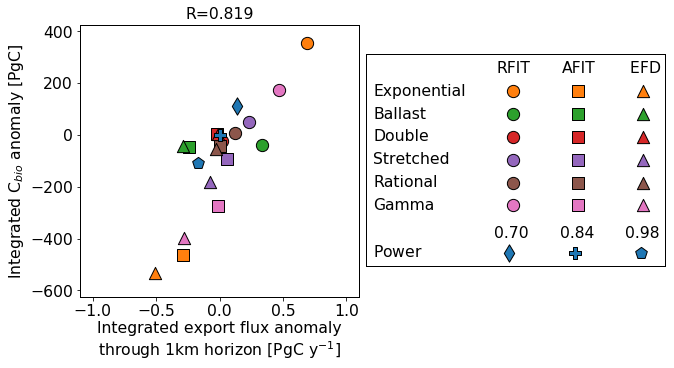

In [8]:
fig2c, f2cax = plt.subplots(figsize=(5, 5),ncols=1,nrows=1)
fig2c.patch.set_facecolor('None')

myorder= [8,6,7,11,10,9,2,0,1,5,4,3,14,12,13,17,16,15]
martid = [18,19,20]
marhdl = [None]*(len(martid)+1)

dexport= intex1k - intex1k[icntrl]
dcreg  = intcreg - intcreg[icntrl]
    
# First plot the different shapes and add a legend
for i in myorder:
    facecolor, edgecolor, marker, label, member = get_point_attributes(paths[i])
    f2cax.scatter(dexport[i],dcreg[i],s=150,
                        label=label,facecolor=facecolor,edgecolor=edgecolor,marker=marker,zorder=1)
    
first_legend = tablelegend(f2cax,ncol=3,loc="lower left",bbox_to_anchor=(0.9,0.32),bbox_transform=fig2c.transFigure,
            row_labels=names, 
            col_labels=['RFIT','AFIT','$\,$EFD'], 
            title_label='',frameon=False)

f2cax.add_artist(first_legend)

# Now plot the martin curve experiments (including initial blank one) with different b-values and add the second legend
for i in range(len(martid)+1):
    if i==0:
        marhdl[i]=f2cax.scatter([],[],facecolor='w',edgecolor='w')
    else:
        facecolor, edgecolor, marker, label, member = get_point_attributes(paths[martid[i-1]])
        marhdl[i]=f2cax.scatter(dexport[martid[i-1]],dcreg[martid[i-1]],s=150,
                                  label=label,facecolor=facecolor,edgecolor=edgecolor,marker=marker,zorder=2)

second_legend = f2cax.legend(marhdl,["Power         $\,$","0.70\n\n","0.84\n\n","0.98\n\n"],
                                   ncol=4,loc="upper left",bbox_to_anchor=(0.9,0.36),bbox_transform=fig2c.transFigure,
                                   handletextpad=-2,frameon=False)

s_export, i_export, r_export, p_export, se_export = st.linregress(dexport[myorder+martid].flatten(),dcreg[myorder+martid].flatten())
#rmse_export = rmse(dcreg[myorder+martid].flatten(),s_export*dexport[myorder+martid].flatten()+i_export)

f2cax.set_title('R={0}'.format(np.round(r_export,3)))
f2cax.set_ylabel('Integrated C$_{bio}$ anomaly [PgC]')
f2cax.set_xlabel('Integrated export flux anomaly\nthrough 1km horizon [PgC y$^{-1}$]')    
f2cax.set_xlim(left=-1.1,right=1.1)
f2cax.set_ylim(top=425,bottom=-625)    

# Add a frame to the composite legend
f2cax.add_patch(plt.Rectangle((0.92,0.21),0.83,0.59,transform=fig2c.transFigure,
                                 clip_on=False,fill=False,edgecolor='k',joinstyle="round",zorder=1))

plt.show()
#fig2c.savefig('/Users/'+gp.getuser()+'/Dropbox/work/Paper_Drafts/exports/Figures/export_export1kvscreg.pdf',facecolor=fig2c.get_facecolor(), edgecolor='none',bbox_inches='tight')

In [9]:
myorder= [8,6,7,11,10,9,2,0,1,5,4,3,14,12,13,17,16,15]
martid = [18,19,20]
print("Control export flux through 1000m is {0} PgC/r".format(np.round(intex1k[icntrl],3)[0]))
pd_exp_mar=pd.DataFrame(np.reshape(dexport[martid],(1,len(martid))).T, 
                     index=["b=0.70","b=0.84","b=0.98"],columns=["Power Law"])
pd_exp_exp=pd.DataFrame(np.reshape(dexport[myorder],(len(expt),len(prof))).T, 
                     index=names,columns=["Relative","Absolute","E-folding"])
print("Change in export flux through 1000m [PgC/y] for Power law...")
print(np.round(pd_exp_mar,3))
print("\n...and remineralization profile experiments:")
print(np.round(pd_exp_exp,3))

Control export flux through 1000m is 1.749 PgC/r
Change in export flux through 1000m [PgC/y] for Power law...
        Power Law
b=0.70      0.141
b=0.84      0.000
b=0.98     -0.173

...and remineralization profile experiments:
             Relative  Absolute  E-folding
Exponential     0.686    -0.289     -0.511
Ballast         0.338    -0.244     -0.292
Double          0.019    -0.021     -0.010
Stretched       0.234     0.056     -0.075
Rational        0.120     0.000     -0.026
Gamma           0.471    -0.009     -0.282


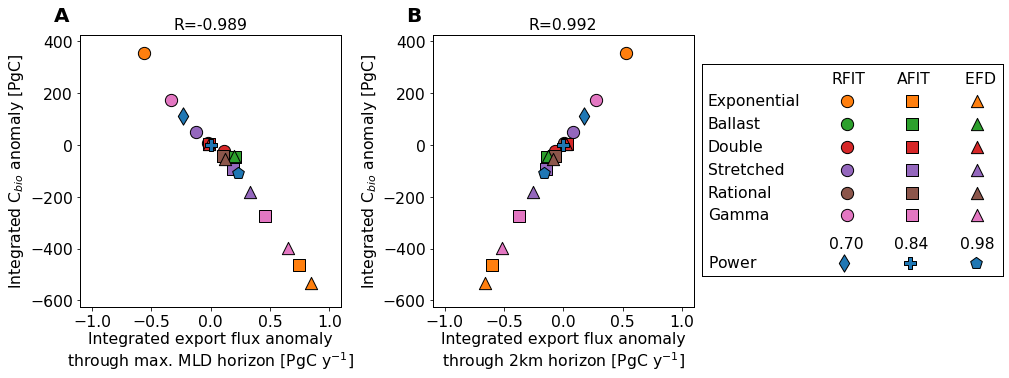

In [10]:
fig2d, f2dax = plt.subplots(figsize=(11, 5),ncols=2,nrows=1)
fig2d.patch.set_facecolor('None')

myorder= [8,6,7,11,10,9,2,0,1,5,4,3,14,12,13,17,16,15]
martid = [18,19,20]
marhdl = [None]*(len(martid)+1)

dexport= intexpmld - intexpmld[icntrl]
dexpor2= intex2k - intex2k[icntrl]
dcreg  = intcreg - intcreg[icntrl]
    
# First plot the different shapes and add a legend
for i in myorder:
    facecolor, edgecolor, marker, label, member = get_point_attributes(paths[i])
    f2dax[0].scatter(dexport[i],dcreg[i],s=150,
                        label=label,facecolor=facecolor,edgecolor=edgecolor,marker=marker,zorder=1)
    
first_legend = tablelegend(f2dax[0], ncol=3,loc="lower left",bbox_to_anchor=(0.9,0.32),bbox_transform=fig2d.transFigure,
            row_labels=names, 
            col_labels=['RFIT','AFIT','$\,$EFD'], 
            title_label='',frameon=False)

f2dax[0].add_artist(first_legend)

# Now plot the martin curve experiments (including initial blank one) with different b-values and add the second legend
for i in range(len(martid)+1):
    if i==0:
        marhdl[i]=f2dax[0].scatter([],[],facecolor='w',edgecolor='w')
    else:
        facecolor, edgecolor, marker, label, member = get_point_attributes(paths[martid[i-1]])
        marhdl[i]=f2dax[0].scatter(dexport[martid[i-1]],dcreg[martid[i-1]],s=150,
                                  label=label,facecolor=facecolor,edgecolor=edgecolor,marker=marker,zorder=2)

second_legend = f2dax[0].legend(marhdl,["Power         $\,$","0.70\n\n","0.84\n\n","0.98\n\n"],
                                   ncol=4,loc="upper left",bbox_to_anchor=(0.9,0.36),bbox_transform=fig2d.transFigure,
                                   handletextpad=-2,frameon=False)

s_export, i_export, r_export, p_export, se_export = st.linregress(dexport[myorder+martid].flatten(),dcreg[myorder+martid].flatten())
#rmse_export = rmse(dcreg[myorder+martid].flatten(),s_export*dexport[myorder+martid].flatten()+i_export)

f2dax[0].set_title('R={0}'.format(np.round(r_export,3)))
f2dax[0].set_ylabel('Integrated C$_{bio}$ anomaly [PgC]')
f2dax[0].set_xlabel('Integrated export flux anomaly\nthrough max. MLD horizon [PgC y$^{-1}$]')    
f2dax[0].set_xlim(left=-1.1,right=1.1)
f2dax[0].set_ylim(top=425,bottom=-625)    


for i in myorder+martid:  
    facecolor, edgecolor, marker, label, member = get_point_attributes(paths[i])       
    f2dax[1].scatter(dexpor2[i],dcreg[i],s=150,label=label,facecolor=facecolor,edgecolor=edgecolor,marker=marker)

s_export, i_export, r_export, p_export, se_export = st.linregress(dexpor2[myorder+martid].flatten(),dcreg[myorder+martid].flatten())
#rmse_export = rmse(dcreg.flatten(),s_export*dexpor2.flatten()+i_export)

f2dax[1].set_title('R={0}'.format(np.round(r_export,3)))
f2dax[1].set_ylabel('Integrated C$_{bio}$ anomaly [PgC]')
f2dax[1].set_xlabel('Integrated export flux anomaly\nthrough 2km horizon [PgC y$^{-1}$]')    
f2dax[1].set_xlim(left=-1.1,right=1.1)
f2dax[1].set_ylim(top=425,bottom=-625)      

# Add a frame to the composite legend
f2dax[1].add_patch(plt.Rectangle((0.91,0.21),0.38,0.59,transform=fig2d.transFigure,clip_on=False,fill=False,edgecolor='k',joinstyle="round",zorder=1))

label_axes(f2dax)                   

plt.subplots_adjust(wspace=0.35)    
plt.show()
#fig2d.savefig('/Users/'+gp.getuser()+'/Dropbox/work/Paper_Drafts/exports/Figures/export_maxmld2kmexpvscreg.pdf',facecolor=fig2d.get_facecolor(), edgecolor='none',bbox_inches='tight')

In [11]:
myorder= [8,6,7,11,10,9,2,0,1,5,4,3,14,12,13,17,16,15]
martid = [18,19,20]
print("Control export flux through MLD is {0} PgC/y".format(np.round(intexpmld[icntrl],3)[0]))
pd_mld_mar=pd.DataFrame(np.reshape(dexport[martid],(1,len(martid))).T, 
                     index=["b=0.70","b=0.84","b=0.98"],columns=["Power Law"])
pd_mld_exp=pd.DataFrame(np.reshape(dexport[myorder],(len(expt),len(prof))).T, 
                     index=names,columns=["Relative","Absolute","E-folding"])
print("Change in export flux through MLD [PgC/y] for Power law...")
print(np.round(pd_mld_mar,3))
print("\n...and remineralization profile experiments:")
print(np.round(pd_mld_exp,3))
print("")
print("Control export flux through 2000m is {0} PgC/y".format(np.round(intex2k[icntrl],3)[0]))
pd_exp2k_mar=pd.DataFrame(np.reshape(dexpor2[martid],(1,len(martid))).T, 
                     index=["b=0.70","b=0.84","b=0.98"],columns=["Power Law"])
pd_exp2k_exp=pd.DataFrame(np.reshape(dexpor2[myorder],(len(expt),len(prof))).T, 
                     index=names,columns=["Relative","Absolute","E-folding"])
print("Change in export flux through 2000m [PgC/y] for Power law...")
print(np.round(pd_exp2k_mar,3))
print("\n...and remineralization profile experiments:")
print(np.round(pd_exp2k_exp,3))
print("")
print("...and Control biological carbon reservoir is {0} PgC".format(np.round(intcreg[icntrl],3)[0]))
pd_creg_mar=pd.DataFrame(np.reshape(dcreg[martid],(1,len(martid))).T, 
                     index=["b=0.70","b=0.84","b=0.98"],columns=["Power Law"])
pd_creg_exp=pd.DataFrame(np.reshape(dcreg[myorder],(len(expt),len(prof))).T, 
                     index=names,columns=["Relative","Absolute","E-folding"])
print("Change in CREG [PgC] for Power law...")
print(np.round(pd_creg_mar,3))
print("\n...and remineralization profile experiments:")
print(np.round(pd_creg_exp,3))

Control export flux through MLD is 2.349 PgC/y
Change in export flux through MLD [PgC/y] for Power law...
        Power Law
b=0.70     -0.236
b=0.84      0.000
b=0.98      0.230

...and remineralization profile experiments:
             Relative  Absolute  E-folding
Exponential    -0.558     0.745      0.845
Ballast         0.124     0.205      0.201
Double          0.111    -0.017     -0.011
Stretched      -0.127     0.188      0.329
Rational       -0.025     0.100      0.124
Gamma          -0.330     0.454      0.653

Control export flux through 2000m is 0.802 PgC/y
Change in export flux through 2000m [PgC/y] for Power law...
        Power Law
b=0.70      0.172
b=0.84      0.000
b=0.98     -0.159

...and remineralization profile experiments:
             Relative  Absolute  E-folding
Exponential     0.525    -0.598     -0.662
Ballast        -0.097    -0.138     -0.130
Double         -0.069     0.031      0.025
Stretched       0.085    -0.142     -0.253
Rational        0.009    -0.069

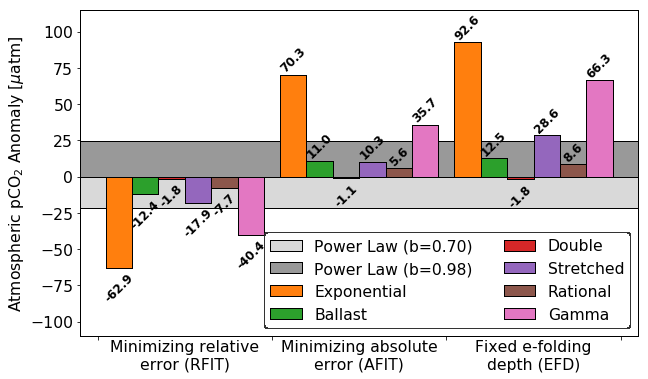

In [12]:
fig4, f4ax = plt.subplots(figsize=(10, 6),ncols=1,nrows=1)
fig4.patch.set_facecolor('None')
myorder= [8,6,7,11,10,9,2,0,1,5,4,3,14,12,13,17,16,15]
martid = [18,19,20]

# Define nice colormap
#colors=['#305cd0','#00a2ff','#6d868a','#fae430','#ff11300','#ee220d']
#mycmap = mp.colors.LinearSegmentedColormap.from_list('Zissou',[mp.colors.hex2color(x) for x in colors], N=64)
mycmap = plt.cm.get_cmap(mp.cm.tab10)

x = np.linspace(0,6,7)  # the label locations
width = 1/6  # the width of the bars
dx = np.arange(-5*width/2,6*width/2,width)
bval=np.linspace(0.7,0.98,3)

for jj in range(0,6):
    bars_rel = f4ax.bar(1+dx[jj],   datmpco2[myorder[jj]   ],width,linewidth=1,color=mycmap(jj+1),edgecolor="black",label=names[jj])
    label_bars(bars_rel,f4ax,weight='bold',fontsize=12,rotation=45)
    f4ax.plot([1+dx[jj]-width/2, 1+dx[jj]+width/2],[0, 0],linewidth=1,color="black")

    bars_abs = f4ax.bar(2.1+dx[jj], datmpco2[myorder[jj+6] ],width,linewidth=1,color=mycmap(jj+1),edgecolor="black")
    label_bars(bars_abs,f4ax,weight='bold',fontsize=12,rotation=45)
    f4ax.plot([2.1+dx[jj]-width/2, 1+dx[jj]+width/2],[0, 0],linewidth=1,color="black")

    bars_efd = f4ax.bar(3.2+dx[jj], datmpco2[myorder[jj+12]],width,linewidth=1,color=mycmap(jj+1),edgecolor="black")
    label_bars(bars_efd,f4ax,weight='bold',fontsize=12,rotation=45)
    f4ax.plot([3.2+dx[jj]-width/2, 2.1+dx[jj]+width/2],[0, 0],linewidth=1,color="black")

# Add the Martin curve results as patches
rect0_70 = f4ax.add_patch(plt.Rectangle((np.min(f4ax.get_xlim()), np.min((0,datmpco2[martid[0]][0]))), np.diff(f4ax.get_xlim()), np.abs(datmpco2[martid[0]][0]),
                         facecolor="0.85",edgecolor="black",zorder=-1,label="Power Law (b=0.70)")
                      )
rect0_84 = f4ax.add_patch(plt.Rectangle((np.min(f4ax.get_xlim()), np.min((0,datmpco2[martid[1]][0]))), np.diff(f4ax.get_xlim()), np.abs(datmpco2[martid[1]][0]),
                         facecolor="0.7",edgecolor="black",zorder=-1) #,label="Power Law (b=0.84)")
                      )
rect0_98 = f4ax.add_patch(plt.Rectangle((np.min(f4ax.get_xlim()), np.min((0,datmpco2[martid[2]][0]))), np.diff(f4ax.get_xlim()), np.abs(datmpco2[martid[2]][0]),
                         facecolor="0.6",edgecolor="black",zorder=-1,label="Power Law (b=0.98)")
                      )
#rect1_0 = f4ax.add_patch(plt.Rectangle((np.min(f4ax.get_xlim()), np.min((0,datmpco2[martid[3]][0]))), np.diff(f4ax.get_xlim()), np.abs(datmpco2[martid[3]][0]),
#                         facecolor="0.6",edgecolor="black",zorder=-1,label="Power Law (b=1.0)")
#                      )

# Add some text for labels, title and custom x-axis tick labels, etc.
f4ax.legend(loc="lower right",ncol=2,edgecolor='black')            
f4ax.set_ylim(top=115,bottom=-110)
f4ax.set_yticks(np.arange(-100,125,25))
f4ax.set_xticks(np.arange(1,4,1.1),minor=True)
f4ax.set_xticks(np.arange(0.45,4.75,1.1))
f4ax.xaxis.set_tick_params(which="minor",length=0)
f4ax.set_ylabel('Atmospheric pCO$_2$ Anomaly [$\mu$atm]')
labels=['Minimizing relative\nerror (RFIT)','Minimizing absolute\nerror (AFIT)','Fixed e-folding\ndepth (EFD)']
f4ax.set_xticklabels(labels,minor=True)
f4ax.set_xticklabels([],minor=False)

plt.show()
#fig4.savefig('/Users/'+gp.getuser()+'/Dropbox/work/Paper_Drafts/exports/Figures/export_pco2bar_grey.pdf',facecolor=fig4.get_facecolor(), edgecolor='none',bbox_inches='tight')

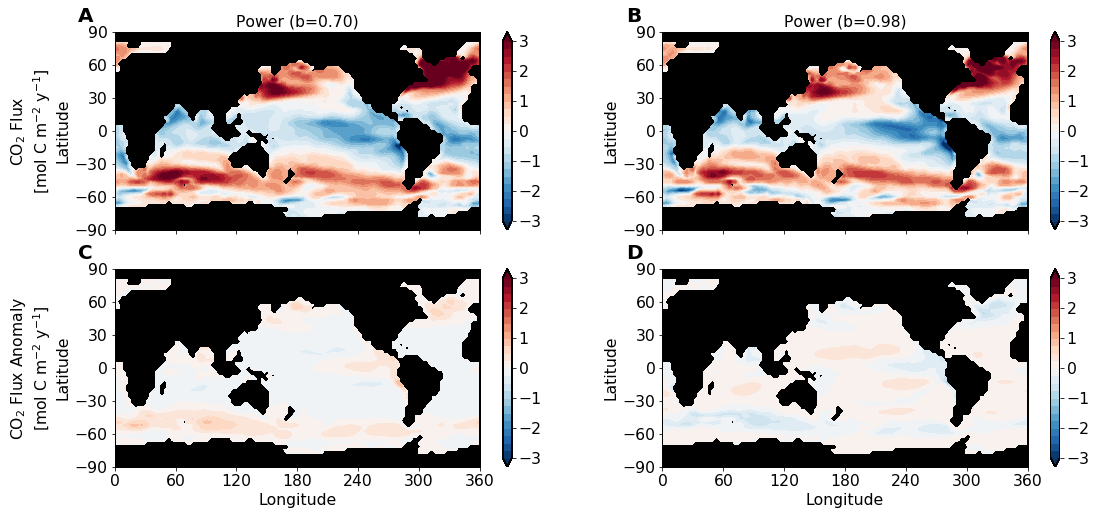

In [13]:
figcols=2
figrows=2

fig5, (f5ax) = plt.subplots(figsize=(18, 8),ncols=figcols,nrows=figrows,sharex=True)
fig5.patch.set_facecolor('None')
f5cax  = f5ax.copy()
f5cbar = f5ax.copy()

myneworder=list(range(18,21))
myneworder.remove(icntrl)

cname=paths[icntrl].split('/')[-3]

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    for xi in range(figcols):
        name=paths[myneworder[xi]].split('/')[-3]
        
        facecolor, edgecolor, marker, label, series = get_point_attributes(paths[myneworder[xi]])    

        f5cax[0,xi]=f5ax[0,xi].contourf(co2_flux['XC'],co2_flux['YC'],((co2_flux[name])*grid_data.cmask.isel(ZC=0)),
                                   levels=(np.arange(-3,3.25,0.25)),cmap='RdBu_r',extend='both')
        for a in f5ax[0,xi].collections:
            a.set_edgecolor("face")
        f5cbar[0,xi]=fig5.colorbar(f5cax[0,xi],ax=f5ax[0,xi],ticks=np.arange(-3,4,1),extend='both')
        f5cbar[0,xi].solids.set_edgecolor("face")
        f5ax[0,xi].set_title(label)
        f5ax[0,xi].set_ylim(bottom=-90,top=90)
        f5ax[0,xi].yaxis.set_ticks(np.arange(-90,120,30))
        if xi==0:
            f5ax[0,xi].set_ylabel("CO$_2$ Flux\n[mol C m$^{-2}$ y$^{-1}$]\nLatitude")
        else:
            f5ax[0,xi].set_ylabel("Latitude")
        f5ax[0,xi].set_facecolor("black")
        
        f5cax[1,xi]=f5ax[1,xi].contourf(co2_flux['XC'],co2_flux['YC'],((co2_flux[name]-co2_flux[cname])*grid_data.cmask.isel(ZC=0)),
                                   levels=(np.arange(-3,3.25,0.25)),cmap='RdBu_r',extend='both')
        for a in f5ax[1,xi].collections:
            a.set_edgecolor("face")
        f5cbar[1,xi]=fig5.colorbar(f5cax[1,xi],ax=f5ax[1,xi],ticks=np.arange(-3,4,1),extend='both')
        f5cbar[1,xi].solids.set_edgecolor("face")
        if xi==0:
            f5ax[1,xi].set_ylabel("CO$_2$ Flux Anomaly\n[mol C m$^{-2}$ y$^{-1}$]\nLatitude")
        else:
            f5ax[1,xi].set_ylabel("Latitude")
        f5ax[1,xi].set_ylim(bottom=-90,top=90)
        f5ax[1,xi].yaxis.set_ticks(np.arange(-90,120,30))
        f5ax[1,xi].set_facecolor("black")
        f5ax[1,xi].set_xlabel("Longitude")    
        f5ax[1,xi].set_xlim(left=0,right=360)
        f5ax[1,xi].xaxis.set_ticks(np.arange(0,420,60))
        f5ax[1,xi].set_facecolor("black")
    label_axes(f5ax)
plt.show()
#fig5.savefig('/Users/'+gp.getuser()+'/Dropbox/work/Paper_Drafts/exports/Figures/export_powerlawco2.pdf',facecolor=fig5.get_facecolor(), edgecolor='none',bbox_inches='tight')

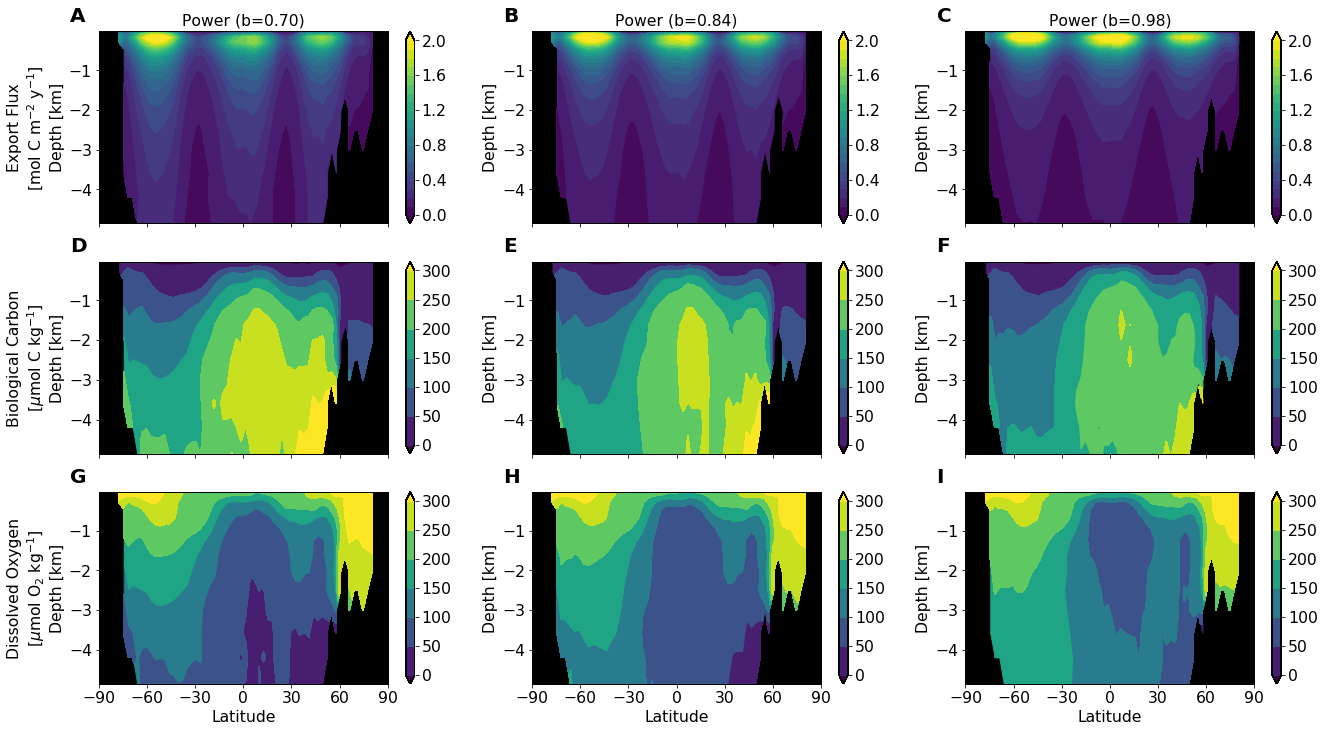

In [14]:
figcols=3
figrows=3

fig6, (f6ax) = plt.subplots(figsize=(22, 12),ncols=figcols,nrows=figrows,sharex=True)
fig6.patch.set_facecolor('None')

myneworder=list(range(18,21))

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    for xi in range(figcols):
        name=paths[myneworder[xi]].split('/')[-3]
        facecolor, edgecolor, marker, label, member = get_point_attributes(paths[myneworder[xi]])    

        f6cax0=f6ax[0,xi].contourf(export_flux['YC'],export_flux['ZC']/1000,(export_flux[name]*grid_data.cmask).mean('XC',skipna=True),
                                   levels=(np.arange(0,2.1,.1)),extend='both')
        for a in f6ax[0,xi].collections:
            a.set_edgecolor("face")
        f6cbar0=fig6.colorbar(f6cax0,ax=f6ax[0,xi],ticks=np.arange(0,2.4,.4),extend='both')
        f6cbar0.solids.set_edgecolor("face")
#        f6ax[0,xi].plot(maxmld['YC'],(-mld.maxmld*grid_data.cmask.isel(ZC=0)).mean('XC',skipna=True)/1000,'k')
        f6ax[0,xi].set_title(label)
        if xi==0:
            f6ax[0,xi].set_ylabel("Export Flux\n[mol C m$^{-2}$ y$^{-1}$]\nDepth [km]")
        else:
            f6ax[0,xi].set_ylabel("Depth [km]")
        f6ax[0,xi].set_facecolor("black")

        f6cax1=f6ax[1,xi].contourf(dic['YC'],dic['ZC']/1000,(creg[name]*grid_data.cmask).mean('XC',skipna=True),
                                   levels=(np.arange(0,350,50)),extend='both')
        for a in f6ax[1,xi].collections:
            a.set_edgecolor("face")
        f6cbar1=fig6.colorbar(f6cax1,ax=f6ax[1,xi],ticks=np.arange(0,350,50),extend='both')
        f6cbar1.solids.set_edgecolor("face")
#        f6ax[1,xi].plot(maxmld['YC'],(-mld.maxmld*grid_data.cmask.isel(ZC=0)).mean('XC',skipna=True)/1000,'k')
        if xi==0:
            f6ax[1,xi].set_ylabel("Biological Carbon\n[$\mu$mol C kg$^{-1}$]\nDepth [km]")
        else:
            f6ax[1,xi].set_ylabel("Depth [km]")
        f6ax[1,xi].set_facecolor("black")

        f6cax2=f6ax[2,xi].contourf(oxy['YC'],oxy['ZC']/1000,(oxy[name]*grid_data.cmask).mean('XC',skipna=True),
                                   levels=(np.arange(0,350,50)),extend='both')
        for a in f6ax[2,xi].collections:
            a.set_edgecolor("face")
        f6cbar2=fig6.colorbar(f6cax2,ax=f6ax[2,xi],ticks=np.arange(0,350,50),extend='both')
        f6cbar2.solids.set_edgecolor("face")
#        f6ax[2,xi].plot(maxmld['YC'],(-mld.maxmld*grid_data.cmask.isel(ZC=0)).mean('XC',skipna=True)/1000,'k')
        if xi==0:
            f6ax[2,xi].set_ylabel("Dissolved Oxygen\n[$\mu$mol O$_2$ kg$^{-1}$]\nDepth [km]")
        else:
            f6ax[2,xi].set_ylabel("Depth [km]")
        f6ax[2,xi].set_xlabel("Latitude")    
        f6ax[2,xi].set_xlim(left=-90,right=90)
        f6ax[2,xi].xaxis.set_ticks(np.arange(-90,120,30))
        f6ax[2,xi].set_facecolor("black")
    label_axes(f6ax)
plt.show()
#fig6.savefig('/Users/'+gp.getuser()+'/Dropbox/work/Paper_Drafts/exports/Figures/export_powerlawvars.pdf',facecolor=fig6.get_facecolor(), edgecolor='none',bbox_inches='tight')

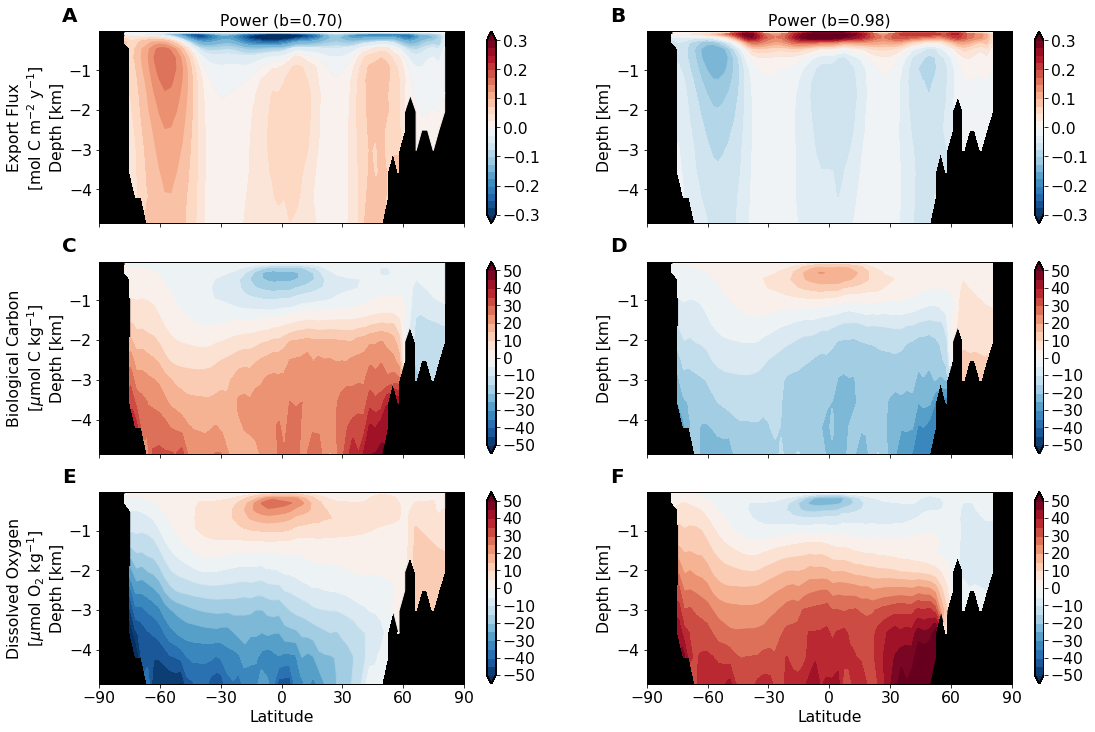

In [15]:
figcols=2
figrows=3

fig7, (f7ax) = plt.subplots(figsize=(18, 12),ncols=figcols,nrows=figrows,sharex=True)
fig7.patch.set_facecolor('None')
f7cax  = f7ax.copy()
f7cbar = f7ax.copy()

myneworder=list(range(18,21))
myneworder.remove(icntrl)

cname=paths[icntrl].split('/')[-3]

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    for xi in range(figcols):
        name=paths[myneworder[xi]].split('/')[-3]
        facecolor, edgecolor, marker, label, series = get_point_attributes(paths[myneworder[xi]])    

        f7cax[0,xi]=f7ax[0,xi].contourf(export_flux['YC'],export_flux['ZC']/1000,((export_flux[name]-export_flux[cname])*grid_data.cmask).mean('XC',skipna=True),
                                   levels=(np.arange(-0.3,0.325,0.025)),cmap='RdBu_r',extend='both')
        for a in f7ax[0,xi].collections:
            a.set_edgecolor("face")
        f7cbar[0,xi]=fig7.colorbar(f7cax[0,xi],ax=f7ax[0,xi],ticks=np.arange(-.3,.4,.1),extend='both')
        f7cbar[0,xi].solids.set_edgecolor("face")
#        f7ax[0,xi].plot(maxmld['YC'],(-mld.maxmld*grid_data.cmask.isel(ZC=0)).mean('XC',skipna=True)/1000,'k')
        f7ax[0,xi].set_title(label)
        if xi==0:
            f7ax[0,xi].set_ylabel("Export Flux\n[mol C m$^{-2}$ y$^{-1}$]\nDepth [km]")
        else:
            f7ax[0,xi].set_ylabel("Depth [km]")
        f7ax[0,xi].set_facecolor("black")

        f7cax[1,xi]=f7ax[1,xi].contourf(dic['YC'],dic['ZC']/1000,((creg[name]-creg[cname])*grid_data.cmask).mean('XC',skipna=True),
                                   levels=(np.arange(-50,55,5)),cmap='RdBu_r',extend='both')
        for a in f7ax[1,xi].collections:
            a.set_edgecolor("face")
        f7cbar[1,xi]=fig7.colorbar(f7cax[1,xi],ax=f7ax[1,xi],ticks=np.arange(-50,60,10),extend='both')
        f7cbar[1,xi].solids.set_edgecolor("face")
#        f7ax[1,xi].plot(maxmld['YC'],(-mld.maxmld*grid_data.cmask.isel(ZC=0)).mean('XC',skipna=True)/1000,'k')
        if xi==0:
            f7ax[1,xi].set_ylabel("Biological Carbon\n[$\mu$mol C kg$^{-1}$]\nDepth [km]")
        else:
            f7ax[1,xi].set_ylabel("Depth [km]")
        f7ax[1,xi].set_facecolor("black")

        f7cax[2,xi]=f7ax[2,xi].contourf(oxy['YC'],oxy['ZC']/1000,((oxy[name]-oxy[cname])*grid_data.cmask).mean('XC',skipna=True),
                                   levels=(np.arange(-50,55,5)),cmap='RdBu_r',extend='both')
        for a in f7ax[2,xi].collections:
            a.set_edgecolor("face")
        f7cbar[2,xi]=fig7.colorbar(f7cax[2,xi],ax=f7ax[2,xi],ticks=np.arange(-50,60,10),extend='both')
        f7cbar[2,xi].solids.set_edgecolor("face")
#        f7ax[2,xi].plot(maxmld['YC'],(-mld.maxmld*grid_data.cmask.isel(ZC=0)).mean('XC',skipna=True)/1000,'k')
        if xi==0:
            f7ax[2,xi].set_ylabel("Dissolved Oxygen\n[$\mu$mol O$_2$ kg$^{-1}$]\nDepth [km]")
        else:
            f7ax[2,xi].set_ylabel("Depth [km]")
        f7ax[2,xi].set_xlabel("Latitude")    
        f7ax[2,xi].set_xlim(left=-90,right=90)
        f7ax[2,xi].xaxis.set_ticks(np.arange(-90,120,30))
        f7ax[2,xi].set_facecolor("black")
    label_axes(f7ax)
    plt.show()
#    fig7.savefig('/Users/'+gp.getuser()+'/Dropbox/work/Paper_Drafts/exports/Figures/export_powerlawanom.pdf',facecolor=fig7.get_facecolor(), edgecolor='none',bbox_inches='tight')

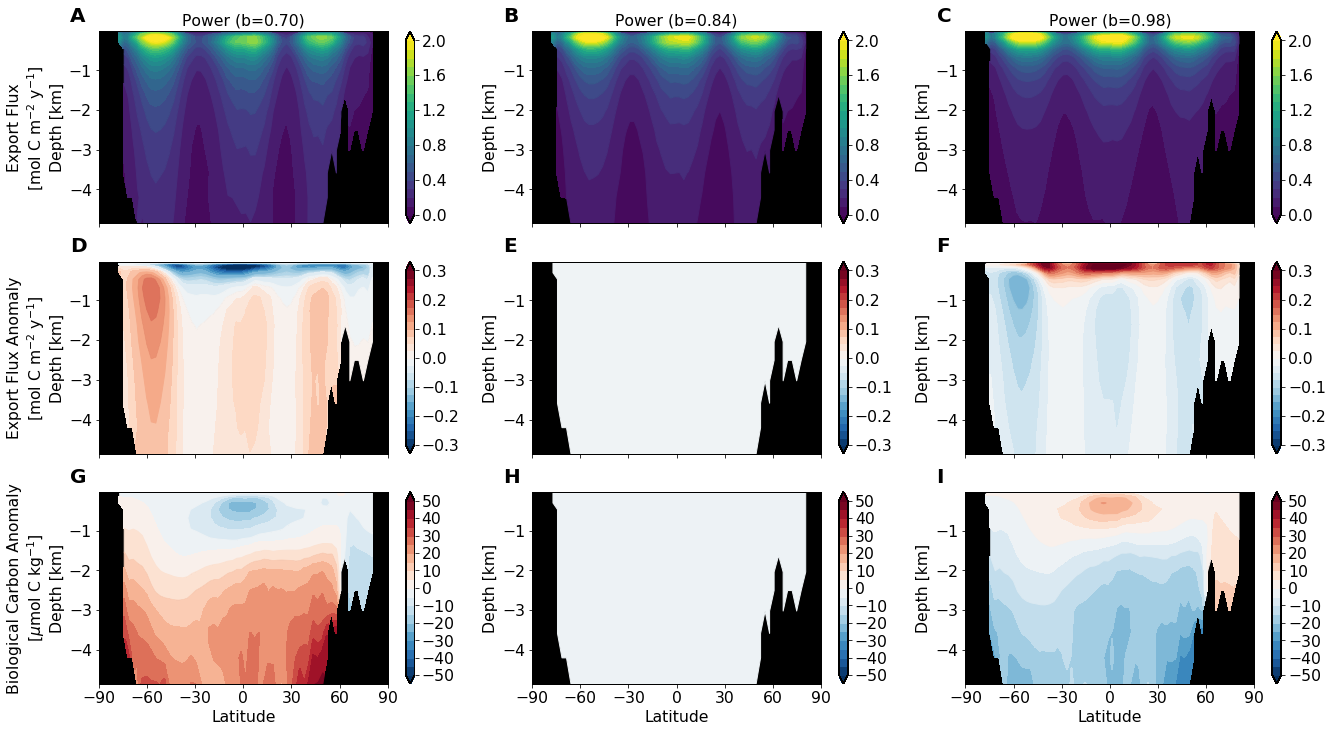

In [16]:
figcols=3
figrows=3

fig7a, (f7aax) = plt.subplots(figsize=(22, 12),ncols=figcols,nrows=figrows,sharex=True)
fig7a.patch.set_facecolor('None')

myneworder=list(range(18,21))

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    for xi in range(figcols):
        name=paths[myneworder[xi]].split('/')[-3]
        facecolor, edgecolor, marker, label, member = get_point_attributes(paths[myneworder[xi]])    

        f7acax0=f7aax[0,xi].contourf(export_flux['YC'],export_flux['ZC']/1000,(export_flux[name]*grid_data.cmask).mean('XC',skipna=True),
                                     levels=(np.arange(0,2.1,0.1)),extend='both')
        for a in f7aax[0,xi].collections:
            a.set_edgecolor("face")
        f7acbar0=fig7a.colorbar(f7acax0,ax=f7aax[0,xi],ticks=np.arange(0,2.4,.4),extend='both')
        f7acbar0.solids.set_edgecolor("face")
#        f7aax[0,xi].plot(maxmld['YC'],(-mld.maxmld*grid_data.cmask.isel(ZC=0)).mean('XC',skipna=True)/1000,'k')
        f7aax[0,xi].set_title(label)
        if xi==0:
            f7aax[0,xi].set_ylabel("Export Flux\n[mol C m$^{-2}$ y$^{-1}$]\nDepth [km]")
        else:
            f7aax[0,xi].set_ylabel("Depth [km]")
        f7aax[0,xi].set_facecolor("black")

        f7acax1=f7aax[1,xi].contourf(export_flux['YC'],export_flux['ZC']/1000,((export_flux[name]-export_flux[cname])*grid_data.cmask).mean('XC',skipna=True),
                                     levels=(np.arange(-.3,.325,0.025)),cmap='RdBu_r',extend='both')
        for a in f7aax[1,xi].collections:
            a.set_edgecolor("face")
        f7acbar1=fig7a.colorbar(f7acax1,ax=f7aax[1,xi],ticks=np.arange(-.3,.4,.1),extend='both')
        f7acbar1.solids.set_edgecolor("face")
#        f7aax[1,xi].plot(maxmld['YC'],(-mld.maxmld*grid_data.cmask.isel(ZC=0)).mean('XC',skipna=True)/1000,'k')
        if xi==0:
            f7aax[1,xi].set_ylabel("Export Flux Anomaly\n[mol C m$^{-2}$ y$^{-1}$]\nDepth [km]")
        else:
            f7aax[1,xi].set_ylabel("Depth [km]")
        f7aax[1,xi].set_facecolor("black")

        f7acax2=f7aax[2,xi].contourf(dic['YC'],dic['ZC']/1000,((creg[name]-creg[cname])*grid_data.cmask).mean('XC',skipna=True),
                                   levels=(np.arange(-50,55,5)),cmap='RdBu_r',extend='both')
        for a in f7aax[2,xi].collections:
            a.set_edgecolor("face")
        f7acbar2=fig7a.colorbar(f7acax2,ax=f7aax[2,xi],ticks=np.arange(-50,60,10),extend='both')
        f7acbar2.solids.set_edgecolor("face")
#        f7aax[2,xi].plot(maxmld['YC'],(-mld.maxmld*grid_data.cmask.isel(ZC=0)).mean('XC',skipna=True)/1000,'k')
        if xi==0:
            f7aax[2,xi].set_ylabel("Biological Carbon Anomaly\n[$\mu$mol C kg$^{-1}$]\nDepth [km]")
        else:
            f7aax[2,xi].set_ylabel("Depth [km]")
        f7aax[2,xi].set_xlabel("Latitude")    
        f7aax[2,xi].set_xlim(left=-90,right=90)
        f7aax[2,xi].xaxis.set_ticks(np.arange(-90,120,30))
        f7aax[2,xi].set_facecolor("black")
    label_axes(f7aax)
plt.show()
#fig7a.savefig('/Users/'+gp.getuser()+'/Dropbox/work/Paper_Drafts/exports/Figures/export_powerlawvars2.pdf',facecolor=fig7a.get_facecolor(), edgecolor='none',bbox_inches='tight')

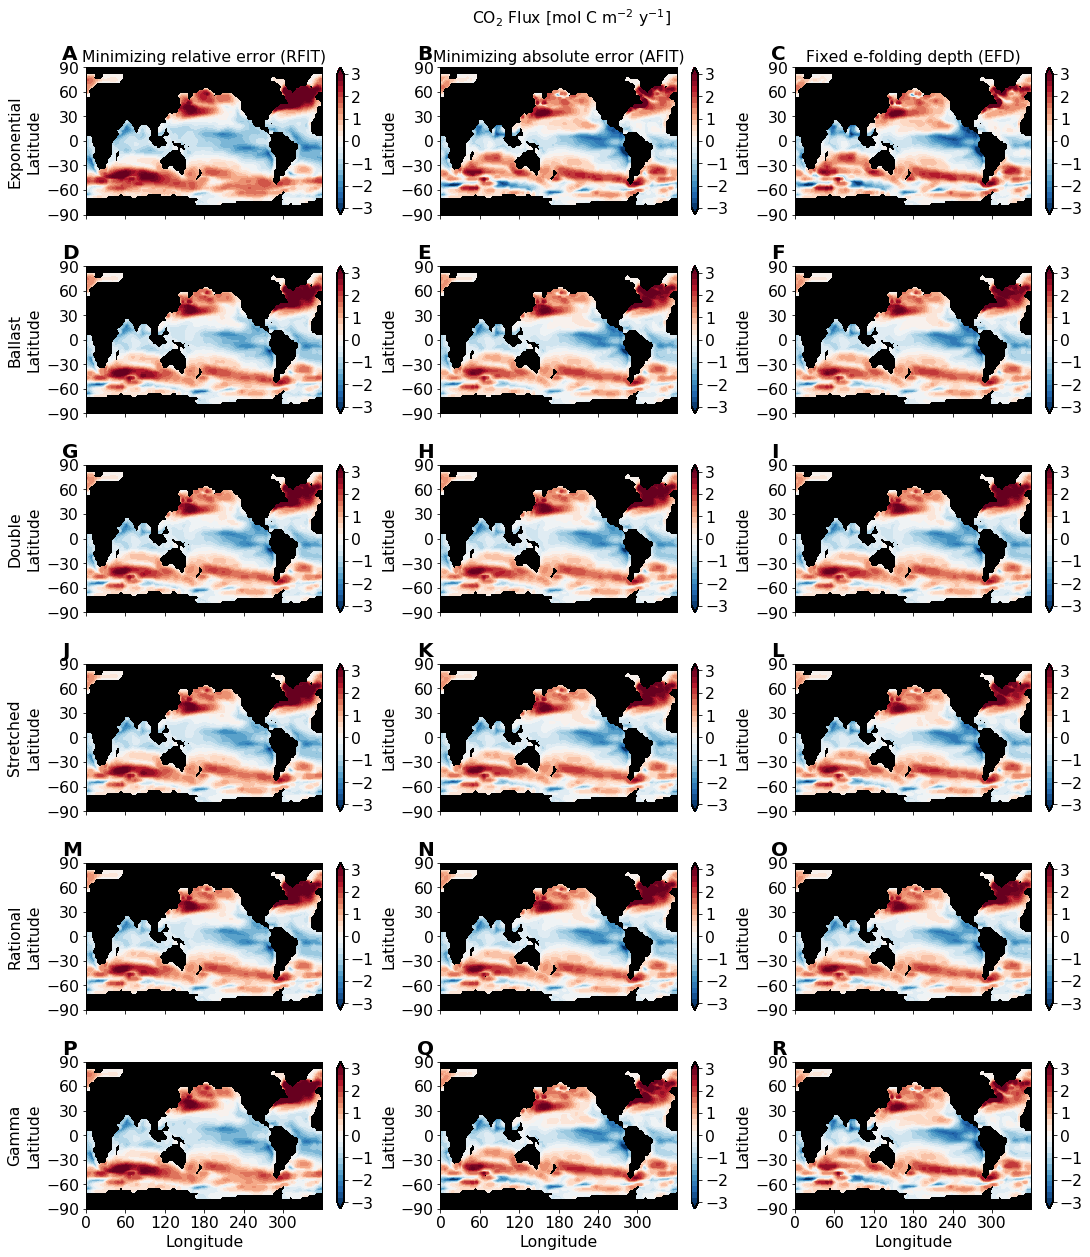

In [17]:
figcols=3
figrows=6

fig8, (f8ax) = plt.subplots(figsize=(18, 21),ncols=figcols,nrows=figrows,sharex=True)
fig8.patch.set_facecolor('None')
f8cax  = f8ax.copy()
f8cbar = f8ax.copy()

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    for xi in range(figcols):
        for yi in range(figrows):
            name=paths[myorder[xi*figrows+yi]].split('/')[-3]
            facecolor, edgecolor, marker, label, member = get_point_attributes(paths[myorder[xi*figrows+yi]])    

            f8cax[yi,xi]=f8ax[yi,xi].contourf(co2_flux['XC'],co2_flux['YC'],((co2_flux[name])*grid_data.cmask.isel(ZC=0)),
                                              levels=(np.arange(-3,3.25,0.25)),cmap='RdBu_r',extend='both')
            for a in f8ax[yi,xi].collections:
                a.set_edgecolor("face")
            f8cbar[yi,xi]=fig8.colorbar(f8cax[yi,xi],ax=f8ax[yi,xi],ticks=np.arange(-3,4,1),extend='both')
            f8cbar[yi,xi].solids.set_edgecolor("face")
            f8ax[yi,xi].set_facecolor("black")
            if xi==0:
                f8ax[yi,xi].set_ylabel("\nLatitude")
                f8ax[yi,xi].text(-120,0,label,fontsize=mp.rcParams['axes.titlesize'],rotation=90,verticalalignment='center')
            else:
                f8ax[yi,xi].set_ylabel("Latitude")
            f8ax[yi,xi].set_ylim(bottom=-90,top=90)
            f8ax[yi,xi].yaxis.set_ticks(np.arange(-90,120,30)) 
            if yi==0:
                f8ax[yi,xi].set_title(member)      
            elif yi==figrows-1:
                f8ax[yi,xi].set_xlabel("Longitude")    
                f8ax[yi,xi].set_xlim(left=0,right=360)
                f8ax[yi,xi].xaxis.set_ticks(np.arange(0,360,60))    
    label_axes(f8ax)
# Can adjust the subplot size
plt.subplots_adjust(hspace=0.35)      
plt.suptitle("CO$_2$ Flux [mol C m$^{-2}$ y$^{-1}$]",x=0.5,y=0.92)
plt.show()
#fig8.savefig('/Users/'+gp.getuser()+'/Dropbox/work/Paper_Drafts/exports/Figures/export_co2flux.pdf',facecolor=fig8.get_facecolor(), edgecolor='none',bbox_inches='tight')

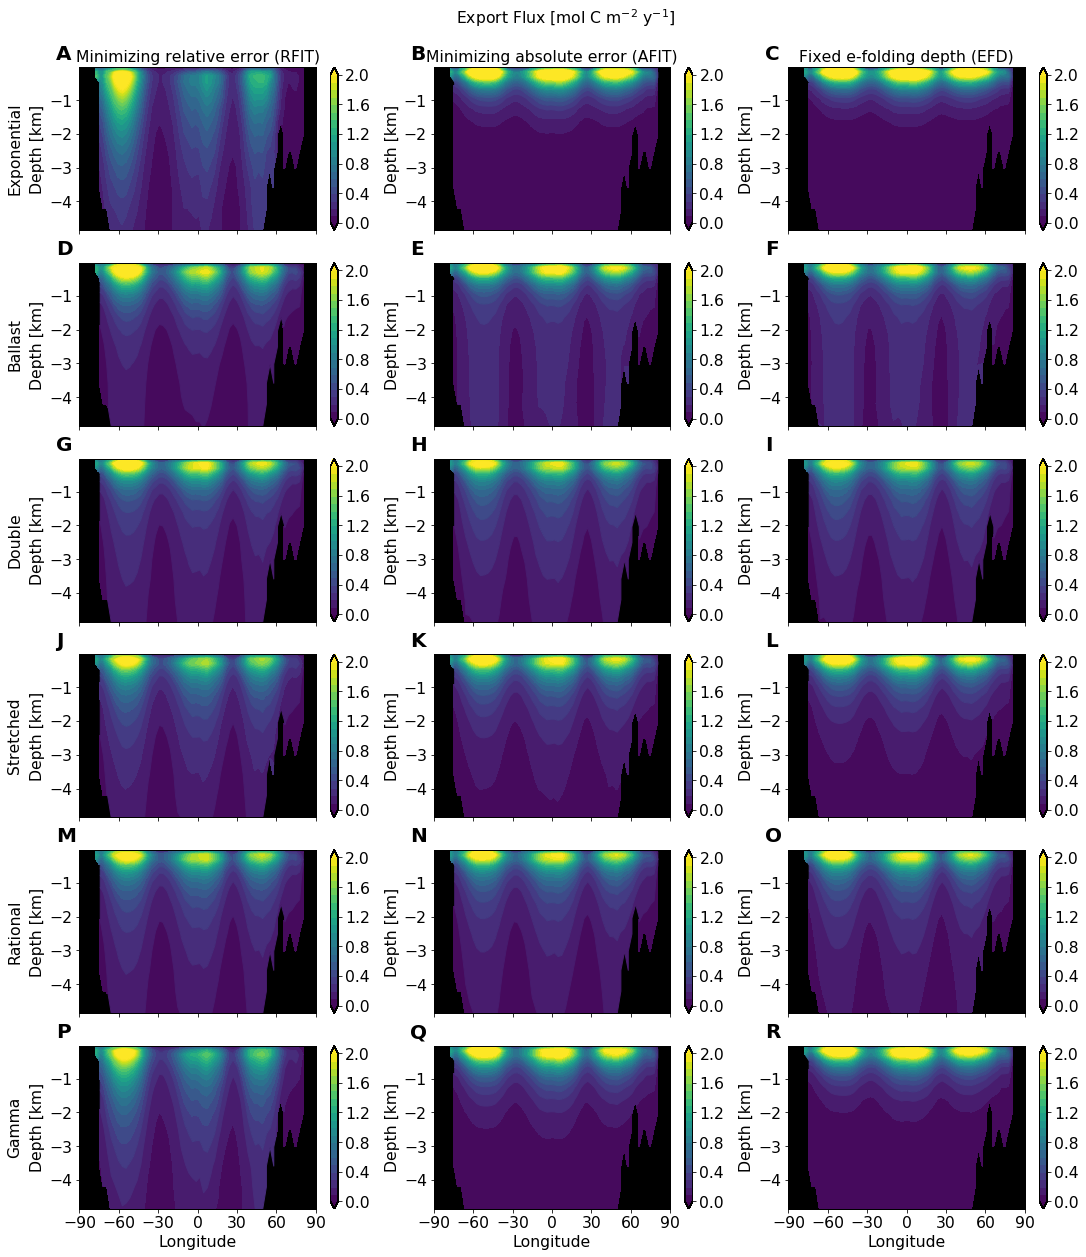

In [18]:
figcols=3
figrows=6

fig9, (f9ax) = plt.subplots(figsize=(18, 21),ncols=figcols,nrows=figrows,sharex=True)
fig9.patch.set_facecolor('None')
f9cax  = f9ax.copy()
f9cbar = f9ax.copy()

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    for xi in range(figcols):
        for yi in range(figrows):
            name=paths[myorder[xi*figrows+yi]].split('/')[-3]
            facecolor, edgecolor, marker, label, member = get_point_attributes(paths[myorder[xi*figrows+yi]])    

            f9cax[yi,xi]=f9ax[yi,xi].contourf(export_flux['YC'],export_flux['ZC']/1000,(export_flux[name]*grid_data.cmask).mean('XC',skipna=True),
                                              levels=(np.arange(0,2.1,.1)),extend='both')
            for a in f9ax[yi,xi].collections:
                a.set_edgecolor("face")
            f9cbar[yi,xi]=fig9.colorbar(f9cax[yi,xi],ax=f9ax[yi,xi],ticks=np.arange(0,2.4,0.4),extend='both')
            f9cbar[yi,xi].solids.set_edgecolor("face")
            f9ax[yi,xi].set_facecolor("black")
#            f9ax[yi,xi].plot(maxmld['YC'],(-mld.maxmld*grid_data.cmask.isel(ZC=0)).mean('XC',skipna=True)/1000,'k')
            if xi==0:
                f9ax[yi,xi].set_ylabel("\nDepth [km]")
                f9ax[yi,xi].text(-145,np.min(export_flux['ZC']/1000)/2,label,fontsize=mp.rcParams['axes.titlesize'],rotation=90,verticalalignment='center')
            else:
                f9ax[yi,xi].set_ylabel("Depth [km]")
            if yi==0:
                f9ax[yi,xi].set_title(member)      
            elif yi==figrows-1:
                f9ax[yi,xi].set_xlabel("Longitude")    
                f9ax[yi,xi].set_xlim(left=-90,right=90)
                f9ax[yi,xi].xaxis.set_ticks(np.arange(-90,120,30))    
label_axes(f9ax) 
plt.suptitle("Export Flux [mol C m$^{-2}$ y$^{-1}$]",x=0.5,y=0.92)
plt.show()
#fig9.savefig('/Users/'+gp.getuser()+'/Dropbox/work/Paper_Drafts/exports/Figures/export_exportflux.pdf',facecolor=fig9.get_facecolor(), edgecolor='none',bbox_inches='tight')

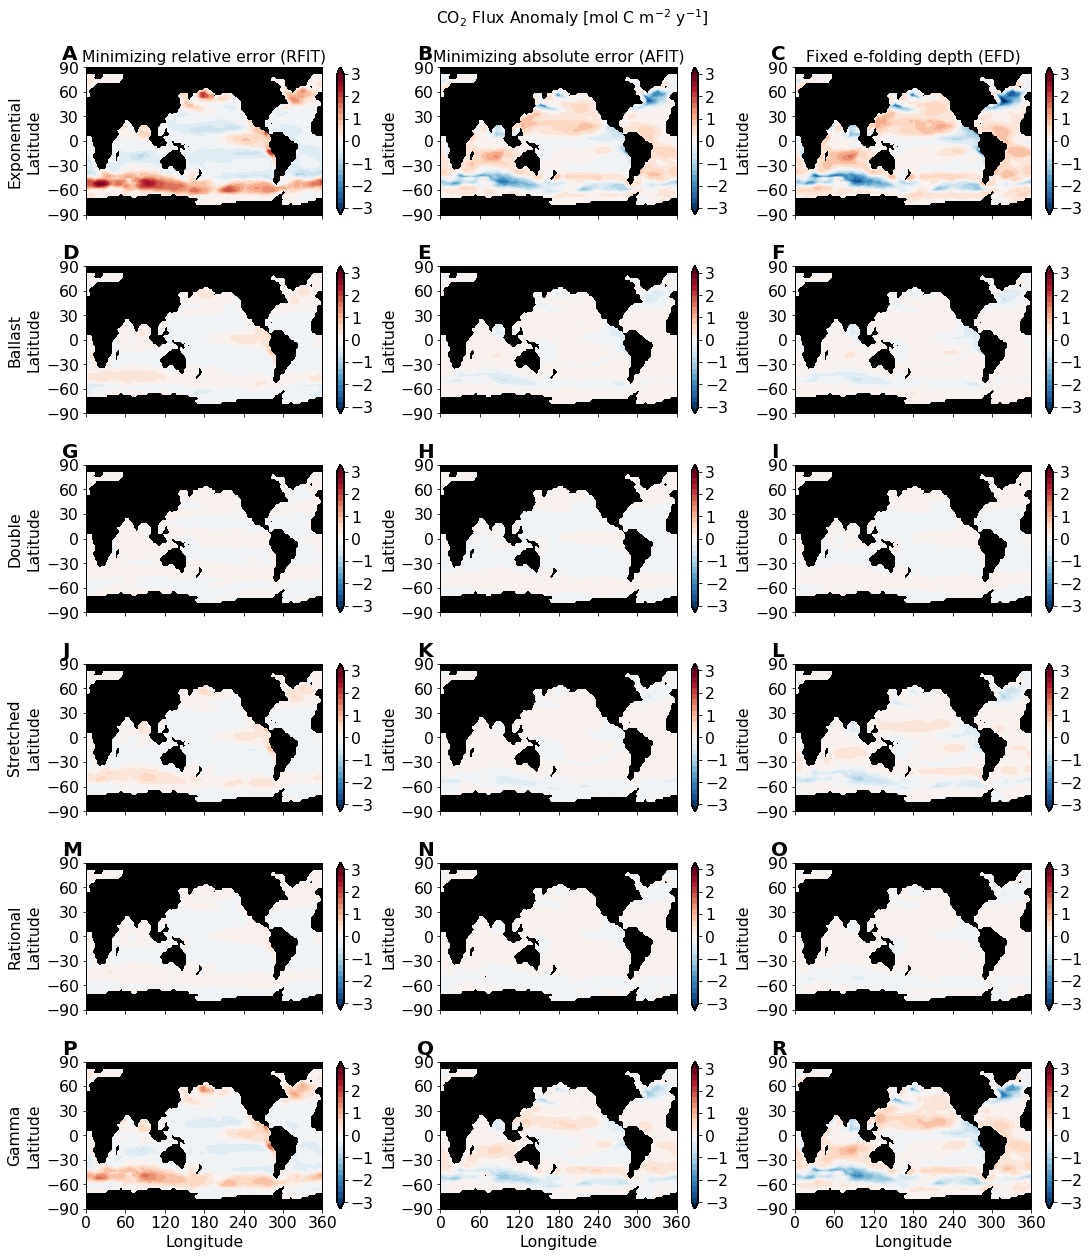

In [19]:
figcols=3
figrows=6

fig10, (f10ax) = plt.subplots(figsize=(18, 21),ncols=figcols,nrows=figrows,sharex=True)
fig10.patch.set_facecolor('None')
f10cax  = f10ax.copy()
f10cbar = f10ax.copy()

cname=paths[icntrl].split('/')[-3]

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    for xi in range(figcols):
        for yi in range(figrows):
            name=paths[myorder[xi*figrows+yi]].split('/')[-3]
            facecolor, edgecolor, marker, label, member = get_point_attributes(paths[myorder[xi*figrows+yi]])    

            f10cax[yi,xi]=f10ax[yi,xi].contourf(co2_flux['XC'],co2_flux['YC'],((co2_flux[name]-co2_flux[cname])*grid_data.cmask.isel(ZC=0)),
                                              levels=(np.arange(-3,3.25,0.25)),cmap='RdBu_r',extend='both')
            for a in f10ax[yi,xi].collections:
                a.set_edgecolor("face")
            f10cbar[yi,xi]=fig10.colorbar(f10cax[yi,xi],ax=f10ax[yi,xi],ticks=np.arange(-3,4,1),extend='both')
            f10cbar[yi,xi].solids.set_edgecolor("face")
            f10ax[yi,xi].set_facecolor("black")
            if xi==0:
                f10ax[yi,xi].set_ylabel("\nLatitude")
                f10ax[yi,xi].text(-120,0,label,fontsize=mp.rcParams['axes.titlesize'],rotation=90,verticalalignment='center')
            else:
                f10ax[yi,xi].set_ylabel("Latitude")
            f10ax[yi,xi].set_ylim(bottom=-90,top=90)
            f10ax[yi,xi].yaxis.set_ticks(np.arange(-90,120,30)) 
            if yi==0:
                f10ax[yi,xi].set_title(member)      
            elif yi==figrows-1:
                f10ax[yi,xi].set_xlabel("Longitude")    
                f10ax[yi,xi].set_xlim(left=0,right=360)
                f10ax[yi,xi].xaxis.set_ticks(np.arange(0,420,60))    
    label_axes(f10ax)
# Can adjust the subplot size
plt.subplots_adjust(hspace=0.35)
plt.suptitle("CO$_2$ Flux Anomaly [mol C m$^{-2}$ y$^{-1}$]",x=0.5,y=0.92)
plt.show()
#fig10.savefig('/Users/'+gp.getuser()+'/Dropbox/work/Paper_Drafts/exports/Figures/export_co2fluxanom.pdf',facecolor=fig10.get_facecolor(), edgecolor='none',bbox_inches='tight')

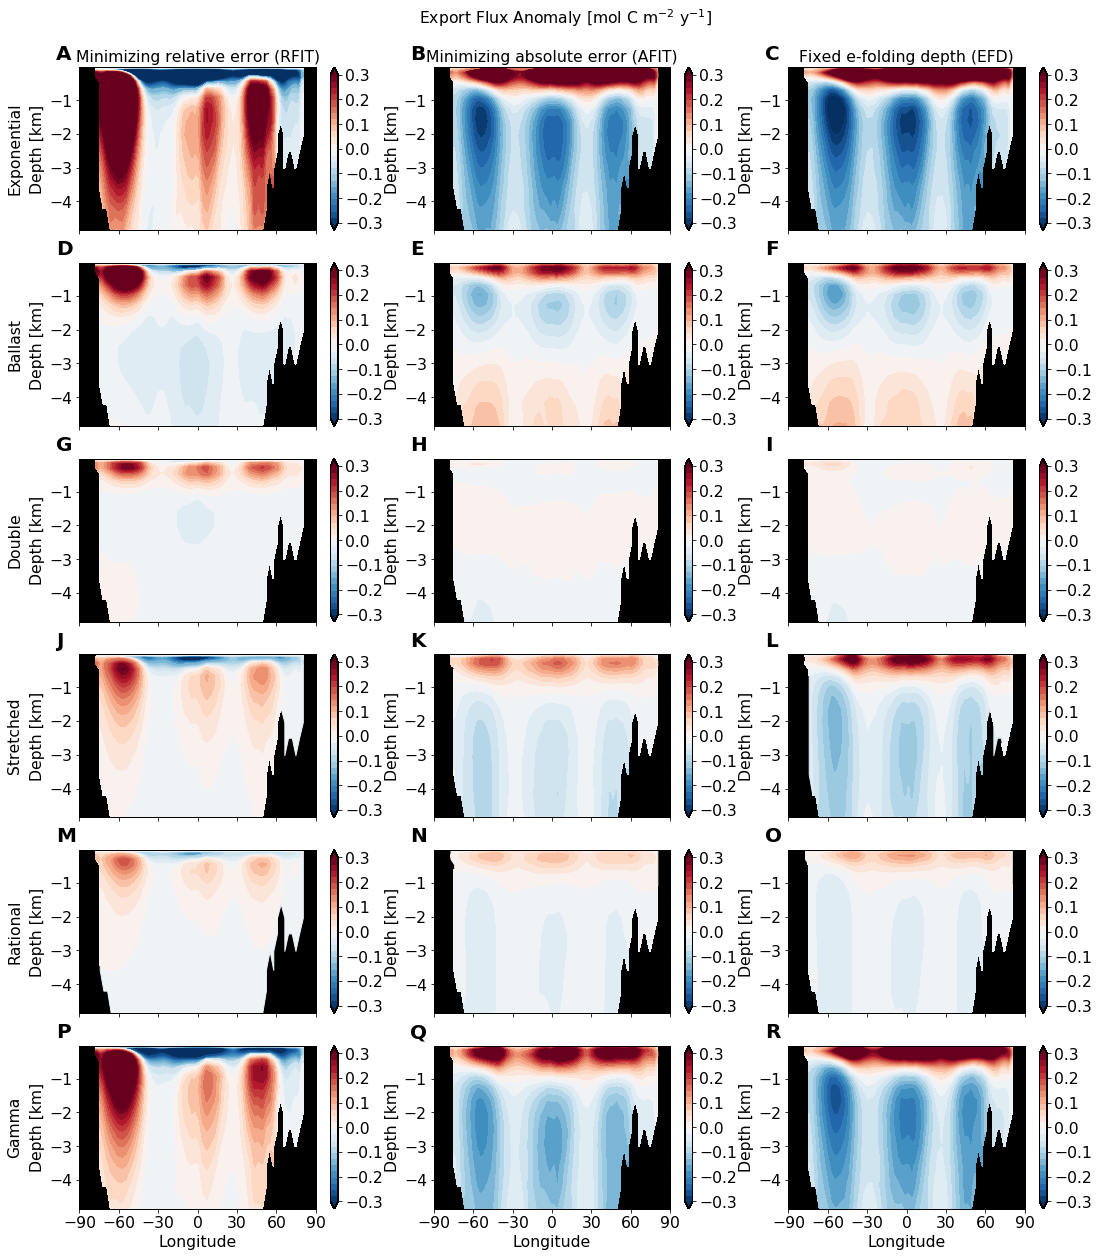

In [20]:
figcols=3
figrows=6

fig11, (f11ax) = plt.subplots(figsize=(18, 21),ncols=figcols,nrows=figrows,sharex=True)
fig11.patch.set_facecolor('None')
f11cax  = f11ax.copy()
f11cbar = f11ax.copy()

cname=paths[icntrl].split('/')[-3]

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    for xi in range(figcols):
        for yi in range(figrows):
            name=paths[myorder[xi*figrows+yi]].split('/')[-3]
            facecolor, edgecolor, marker, label, member = get_point_attributes(paths[myorder[xi*figrows+yi]])    

            f11cax[yi,xi]=f11ax[yi,xi].contourf(export_flux['YC'],export_flux['ZC']/1000,((export_flux[name]-export_flux[cname])*grid_data.cmask).mean('XC',skipna=True),
                                              levels=(np.arange(-.3,.325,0.025)),cmap='RdBu_r',extend='both')
            for a in f11ax[yi,xi].collections:
                a.set_edgecolor("face")
            f11cbar[yi,xi]=fig11.colorbar(f11cax[yi,xi],ax=f11ax[yi,xi],ticks=np.arange(-.3,.4,.1),extend='both')
            f11cbar[yi,xi].solids.set_edgecolor("face")
            f11ax[yi,xi].set_facecolor("black")
#            f11ax[yi,xi].plot(maxmld['YC'],(-mld.maxmld*grid_data.cmask.isel(ZC=0)).mean('XC',skipna=True)/1000,'k')
            if xi==0:
                f11ax[yi,xi].set_ylabel("\nDepth [km]")
                f11ax[yi,xi].text(-145,np.min(export_flux['ZC']/1000)/2,label,fontsize=mp.rcParams['axes.titlesize'],rotation=90,verticalalignment='center')
            else:
                f11ax[yi,xi].set_ylabel("Depth [km]")
            if yi==0:
                f11ax[yi,xi].set_title(member)      
            elif yi==figrows-1:
                f11ax[yi,xi].set_xlabel("Longitude")    
                f11ax[yi,xi].set_xlim(left=-90,right=90)
                f11ax[yi,xi].xaxis.set_ticks(np.arange(-90,120,30))    
    label_axes(f11ax)                
plt.suptitle("Export Flux Anomaly [mol C m$^{-2}$ y$^{-1}$]",x=0.5,y=0.92)
plt.show()
#fig11.savefig('/Users/'+gp.getuser()+'/Dropbox/work/Paper_Drafts/exports/Figures/export_exportanom.pdf',facecolor=fig11.get_facecolor(), edgecolor='none',bbox_inches='tight')

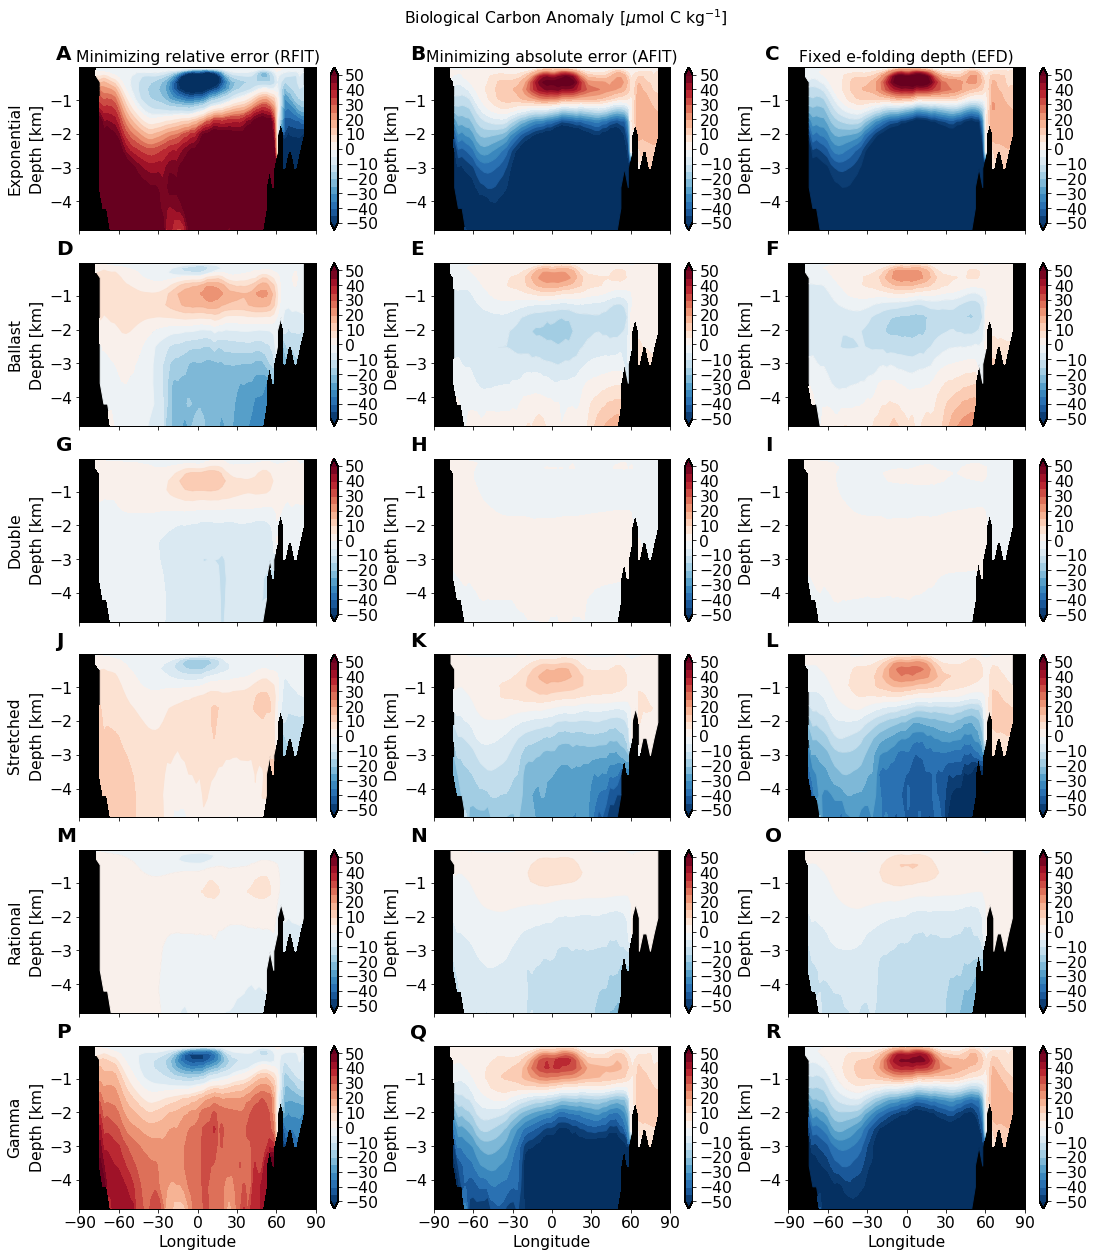

In [21]:
figcols=3
figrows=6

fig12, (f12ax) = plt.subplots(figsize=(18, 21),ncols=figcols,nrows=figrows,sharex=True)
fig12.patch.set_facecolor('None')
f12cax  = f12ax.copy()
f12cbar = f12ax.copy()

cname=paths[icntrl].split('/')[-3]

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    for xi in range(figcols):
        for yi in range(figrows):
            name=paths[myorder[xi*figrows+yi]].split('/')[-3]
            facecolor, edgecolor, marker, label, member = get_point_attributes(paths[myorder[xi*figrows+yi]])    

            f12cax[yi,xi]=f12ax[yi,xi].contourf(dic['YC'],dic['ZC']/1000,((creg[name]-creg[cname])*grid_data.cmask).mean('XC',skipna=True),
                                              levels=(np.arange(-50,55,5)),cmap='RdBu_r',extend='both')
            for a in f12ax[yi,xi].collections:
                a.set_edgecolor("face")
            f12cbar[yi,xi]=fig12.colorbar(f12cax[yi,xi],ax=f12ax[yi,xi],ticks=np.arange(-50,60,10),extend='both')
            f12cbar[yi,xi].solids.set_edgecolor("face")
            f12ax[yi,xi].set_facecolor("black")
#            f12ax[yi,xi].plot(maxmld['YC'],(-mld.maxmld*grid_data.cmask.isel(ZC=0)).mean('XC',skipna=True)/1000,'k')
            if xi==0:
                f12ax[yi,xi].set_ylabel("\nDepth [km]")
                f12ax[yi,xi].text(-145,np.min(dic['ZC']/1000)/2,label,fontsize=mp.rcParams['axes.titlesize'],rotation=90,verticalalignment='center')
            else:
                f12ax[yi,xi].set_ylabel("Depth [km]")
            if yi==0:
                f12ax[yi,xi].set_title(member)      
            elif yi==figrows-1:
                f12ax[yi,xi].set_xlabel("Longitude")    
                f12ax[yi,xi].set_xlim(left=-90,right=90)
                f12ax[yi,xi].xaxis.set_ticks(np.arange(-90,120,30))          
    label_axes(f12ax)
plt.suptitle("Biological Carbon Anomaly [$\mu$mol C kg$^{-1}$]",x=0.5,y=0.92)
plt.show()
#fig12.savefig('/Users/'+gp.getuser()+'/Dropbox/work/Paper_Drafts/exports/Figures/export_creganom.pdf',facecolor=fig12.get_facecolor(), edgecolor='none',bbox_inches='tight')

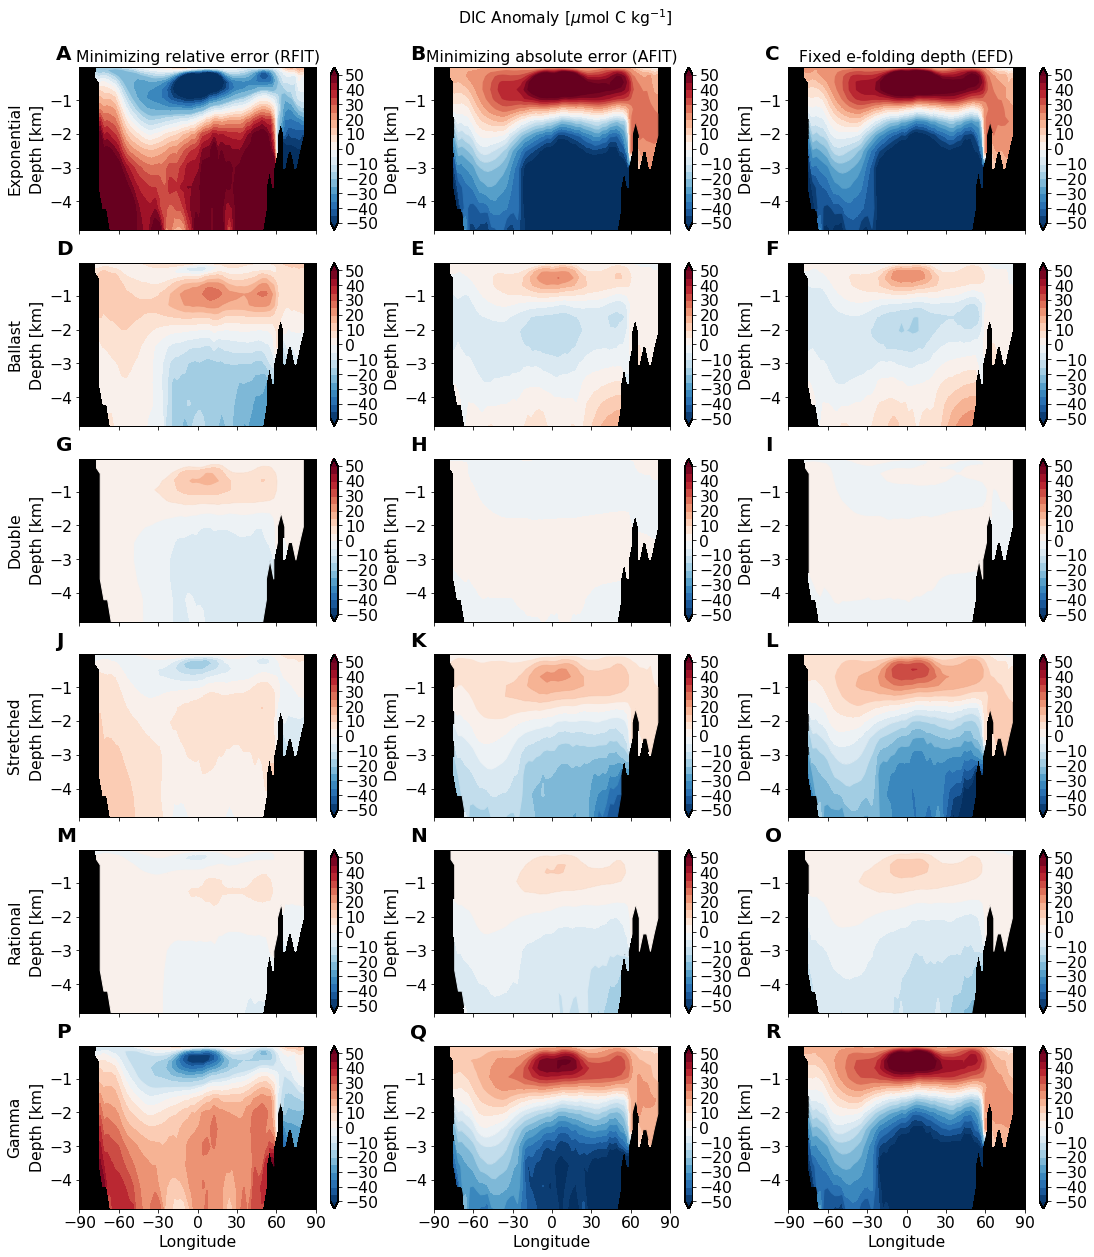

In [22]:
figcols=3
figrows=6

fig13, (f13ax) = plt.subplots(figsize=(18, 21),ncols=figcols,nrows=figrows,sharex=True)
fig13.patch.set_facecolor('None')
f13cax  = f13ax.copy()
f13cbar = f13ax.copy()

cname=paths[icntrl].split('/')[-3]

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    for xi in range(figcols):
        for yi in range(figrows):
            name=paths[myorder[xi*figrows+yi]].split('/')[-3]
            facecolor, edgecolor, marker, label, member = get_point_attributes(paths[myorder[xi*figrows+yi]])    

            f13cax[yi,xi]=f13ax[yi,xi].contourf(dic['YC'],dic['ZC']/1000,((dic[name]-dic[cname])*grid_data.cmask).mean('XC',skipna=True),
                                              levels=(np.arange(-50,55,5)),cmap='RdBu_r',extend='both')
            for a in f13ax[yi,xi].collections:
                a.set_edgecolor("face")
            f13cbar[yi,xi]=fig13.colorbar(f13cax[yi,xi],ax=f13ax[yi,xi],ticks=np.arange(-50,60,10),extend='both')
            f13cbar[yi,xi].solids.set_edgecolor("face")
            f13ax[yi,xi].set_facecolor("black")
#            f13ax[yi,xi].plot(maxmld['YC'],(-mld.maxmld*grid_data.cmask.isel(ZC=0)).mean('XC',skipna=True)/1000,'k')
            if xi==0:
                f13ax[yi,xi].set_ylabel("\nDepth [km]")
                f13ax[yi,xi].text(-145,np.min(dic['ZC']/1000)/2,label,fontsize=mp.rcParams['axes.titlesize'],rotation=90,verticalalignment='center')
            else:
                f13ax[yi,xi].set_ylabel("Depth [km]")
            if yi==0:
                f13ax[yi,xi].set_title(member)      
            elif yi==figrows-1:
                f13ax[yi,xi].set_xlabel("Longitude")    
                f13ax[yi,xi].set_xlim(left=-90,right=90)
                f13ax[yi,xi].xaxis.set_ticks(np.arange(-90,120,30))          
    label_axes(f13ax)
plt.suptitle("DIC Anomaly [$\mu$mol C kg$^{-1}$]",x=0.5,y=0.92)
plt.show()
#fig13.savefig('/Users/'+gp.getuser()+'/Dropbox/work/Paper_Drafts/exports/Figures/export_dicanom.pdf',facecolor=fig13.get_facecolor(), edgecolor='none',bbox_inches='tight')

## The NoFlux experiment has no particulate export flux - all biological production is channelled into dissolved organic matter and remineralized near the surface ocean (DOPfraction=1.0)

In [23]:
noflux = gb.glob('/Volumes/Atlantis/exports_ref0.9/f_noflux/f_*_global/')[0]
name ="f_noflux"

try: 
    data_parms=mitgcm_tools.getparm(noflux+'../input/data') 
except FileNotFoundError:
    try: 
        data_parms=mitgcm_tools.getparm(noflux+'../input/data.orig')
    except FileNotFoundError:
        data_parms=mitgcm_tools.getparm(noflux+'../input/data.001')

data_pkg=mitgcm_tools.getparm(noflux+'../input/data.pkg') 
data_dic=mitgcm_tools.getparm(noflux+'../input/data.dic') 

model_run=mitgcm_tools.open_ncfile(gb.glob(noflux+'tave.*.glob.nc')[0])

grid_data_noflux,xgrid_noflux=mitgcm_tools.loadgrid(gb.glob(noflux+'grid.glob.nc')[0])
grid_data_noflux=grid_data_noflux.transpose('XC','XG','YC','YG','ZC','ZG','ZL','ZR')
grid_data_noflux.close()

grid_data_noflux['T']=model_run.coords["T"]
grid_data_noflux['Tyr']=model_run.coords["T"]/(86400*360)
grid_data_noflux['iter']=model_run.iter

theta=model_run.Ttave.isel(T=-1)
salt=model_run.Stave.isel(T=-1)
model_run.close()

model_run=mitgcm_tools.open_ncfile(gb.glob(noflux+'surfDiag.*.glob.nc')[0],
                                     strange_axes={'Zmd000001':'ZC','Zd000001':'ZL'},
                                     grid=grid_data_noflux)
mld[name]=model_run.MXLDEPTH.isel(T=-1)
model_run.close()

model_run=mitgcm_tools.open_ncfile(gb.glob(noflux+'ptr_tave.*.glob.nc')[0])

dic[name]=model_run.dic.isel(T=-1)*molperm3_2_umolperkg # in umol/kg
alk[name]=model_run.alk.isel(T=-1)*molperm3_2_umolperkg # in umol/kg
po4[name]=model_run.po4.isel(T=-1)*molperm3_2_umolperkg # in umol/kg
oxy[name]=model_run.o2 .isel(T=-1)*molperm3_2_umolperkg # in umol/kg

cpre[name]=model_run.cpre.isel(T=-1)*molperm3_2_umolperkg # in umol/kg
apre[name]=model_run.apre.isel(T=-1)*molperm3_2_umolperkg # in umol/kg
ppre[name]=model_run.ppre.isel(T=-1)*molperm3_2_umolperkg # in umol/kg
opre[name]=model_run.opre.isel(T=-1)*molperm3_2_umolperkg # in umol/kg

creg[name]=(model_run.dic.isel(T=-1)-model_run.cpre.isel(T=-1))*molperm3_2_umolperkg # in umol/kg

intdic [-1] = (grid_data_noflux.cvol*grid_data_noflux.cmask*model_run.dic.isel(T=-1))\
                .sum(("XC","YC","ZC"))*12e-15 # in PgC
intcreg[-1] = (grid_data_noflux.cvol*grid_data_noflux.cmask*(model_run.dic.isel(T=-1)-model_run.cpre.isel(T=-1)))\
                .sum(("XC","YC","ZC"))*12e-15 # in PgC

model_run.close()

pstar[-1]=np.mean((po4[name]-ppre[name])/po4[name]) # fraction

model_run=mitgcm_tools.open_ncfile(gb.glob(noflux+'dicDiag.*.glob.nc')[0],
                                     strange_axes={'Zmd000015':'ZC','Zld000015':'ZL'},
                                     grid=grid_data_noflux)
# Export flux is mol P/m2/s
export_flux[name]=model_run.CEXPFLX.isel(T=-1)*117*(360*86400) # in mol C/m2/yr
intexp [-1] = (grid_data_noflux.rA*grid_data_noflux.cmask*model_run.CEXPFLX.isel(T=-1))\
        .sum(("XC","YC","ZC"))*(360*86400)*117*12e-15 # in PgC/yr 
intex1k[-1] = (grid_data_noflux.rA*grid_data_noflux.cmask.sel(ZC=-1000,method='nearest')
            *model_run.CEXPFLX.isel(T=-1).sel(ZC=-1000,method='nearest'))\
        .sum(("XC","YC"))*(360*86400)*117*12e-15 # in PgC/yr     
intex2k[-1] = (grid_data.rA*grid_data.cmask.sel(ZC=-2000,method='nearest')
            *model_run.CEXPFLX.isel(T=-1).sel(ZC=-2000,method='nearest'))\
        .sum(("XC","YC"))*(360*86400)*117*12e-15 # in PgC/yr
intex3k[-1] = (grid_data.rA*grid_data.cmask.sel(ZC=-3000,method='nearest')
            *model_run.CEXPFLX.isel(T=-1).sel(ZC=-3000,method='nearest'))\
        .sum(("XC","YC"))*(360*86400)*117*12e-15 # in PgC/yr

# Interpolate export fluxes on to mixed layer depth
expmld[name]= model_run.CEXPFLX.isel(T=-1).sel(ZC=-mld['maxmld'],method='nearest')*1e6*117*(360*86400) # in umol C/m2/yr
intexpmld[-1]=(model_run.CEXPFLX.isel(T=-1).sel(ZC=-mld['maxmld'],method='nearest')*
              grid_data_noflux.rA*grid_data_noflux.cmask.sel(ZC=-mld['maxmld'],method='nearest'))\
                .sum(("XC","YC"))*(360*86400)*117*12e-15 # in PgC/yr  

bioprod[-1]= (grid_data_noflux.cvol*grid_data_noflux.cmask*model_run.DICBIOA.isel(T=-1))\
                .sum(("XC","YC","ZC"))*(360*86400)*117*12e-15 # in PgC/yr
model_run.close()

model_run=mitgcm_tools.open_ncfile(gb.glob(noflux+'dic_surfDiag.*.glob.nc')[0],
                                     strange_axes={'Zmd000001':'ZC','Zd000001':'ZL'},
                                     grid=grid_data_noflux)
co2_flux[name]=model_run.DICCFLX.isel(T=-1)*(360*86400) # in molC/m2/yr
model_run.close()

atm_box=mitgcm_tools.get_dicpco2(data_parms,data_dic,grid_data_noflux,path=noflux)
atmpco2[-1]=atm_box.pco2.isel(T=-1).load()*1e6

The axes: T could not be converted
Attributes could not be added for axes: T
The axes: T could not be converted
Attributes could not be added for axes: T
Coordinates added for axes: ZC
Coordinates added for axes: ZC,ZL
The axes: T could not be converted
Attributes could not be added for axes: T
The axes: T could not be converted
Attributes could not be added for axes: T
Coordinates added for axes: ZC
The axes: T could not be converted
Attributes could not be added for axes: T
Coordinates added for axes: ZC
Coordinates added for axes: ZC,ZL
The axes: T could not be converted
Attributes could not be added for axes: T
Coordinates added for axes: ZC
Coordinates added for axes: ZC,ZL


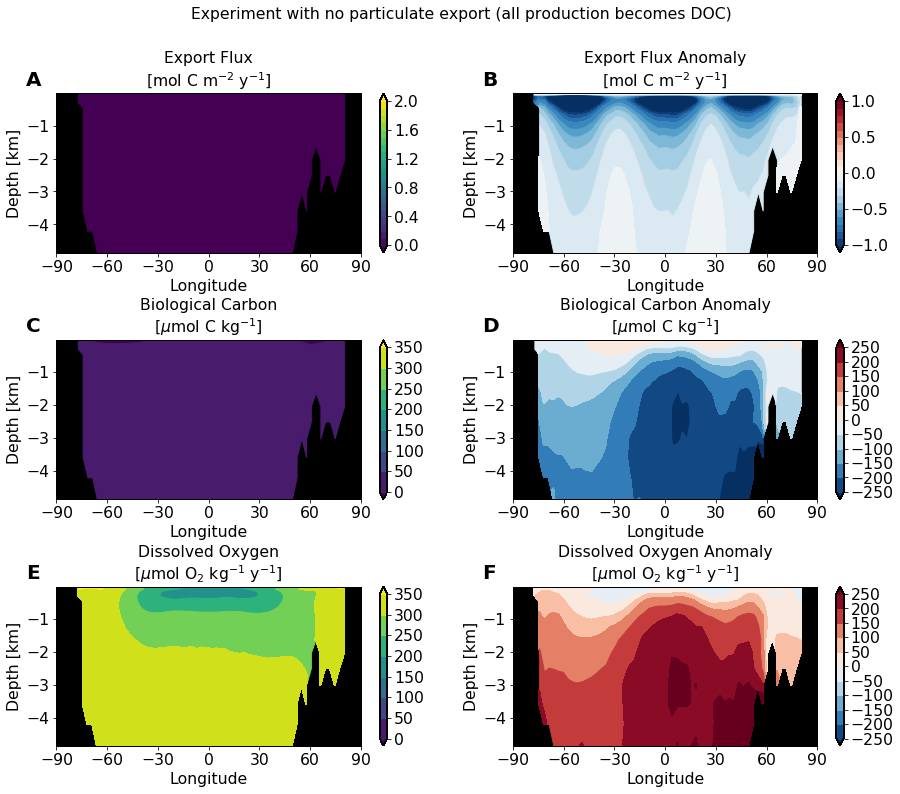

In [24]:
figcols=2
figrows=3

fig14, (f14ax) = plt.subplots(figsize=(15, 12),ncols=figcols,nrows=figrows)
fig14.patch.set_facecolor('None')
f14cax  = f14ax.copy()
f14cbar = f14ax.copy()

name ="f_noflux"
cname=paths[icntrl].split('/')[-3]

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    f14cax[0,0]=f14ax[0,0].contourf(export_flux['YC'],export_flux['ZC']/1000,((export_flux[name])*grid_data_noflux.cmask)
                               .mean('XC',skipna=True),levels=(np.arange(0,2.1,.1)),extend='both')
    for a in f14ax[0,0].collections:
        a.set_edgecolor("face")
    f14cbar[0,0]=fig14.colorbar(f14cax[0,0],ax=f14ax[0,0],ticks=np.arange(0,2.4,.4),extend='both')
    f14cbar[0,0].solids.set_edgecolor("face")
    f14ax[0,0].set_title("Export Flux\n[mol C m$^{-2}$ y$^{-1}$]")
    f14ax[0,0].set_ylabel("Depth [km]")
    f14ax[0,0].set_facecolor("black")
    f14ax[0,0].set_xlabel("Longitude")    
    f14ax[0,0].set_xlim(left=-90,right=90)
    f14ax[0,0].xaxis.set_ticks(np.arange(-90,120,30))
    
    f14cax[0,1]=f14ax[0,1].contourf(export_flux['YC'],export_flux['ZC']/1000,((export_flux[name]-export_flux[cname])*grid_data_noflux.cmask)
                                    .mean('XC',skipna=True),levels=(np.arange(-1.0,1.1,.1)),cmap='RdBu_r',extend='both')
    for a in f14ax[0,1].collections:
        a.set_edgecolor("face")
    f14cbar[0,1]=fig14.colorbar(f14cax[0,1],ax=f14ax[0,1],ticks=np.arange(-1.0,1.5,.5),extend='both')
    f14cbar[0,1].solids.set_edgecolor("face")
    f14ax[0,1].set_title("Export Flux Anomaly\n[mol C m$^{-2}$ y$^{-1}$]")
    f14ax[0,1].set_ylabel("Depth [km]")
    f14ax[0,1].set_facecolor("black")
    f14ax[0,1].set_xlabel("Longitude")    
    f14ax[0,1].set_xlim(left=-90,right=90)
    f14ax[0,1].xaxis.set_ticks(np.arange(-90,120,30))
    
    ###
    f14cax[1,0]=f14ax[1,0].contourf(creg['YC'],creg['ZC']/1000,(creg[name]*grid_data_noflux.cmask)
                                    .mean('XC',skipna=True),levels=(np.arange(0,400,50)),extend='both')
    for a in f14ax[1,0].collections:
        a.set_edgecolor("face")
    f14cbar[1,0]=fig14.colorbar(f14cax[1,0],ax=f14ax[1,0],ticks=np.arange(0,400,50),extend='both')
    f14cbar[1,0].solids.set_edgecolor("face")
    f14ax[1,0].set_title("Biological Carbon\n[$\mu$mol C kg$^{-1}$]")
    f14ax[1,0].set_ylabel("Depth [km]")
    f14ax[1,0].set_facecolor("black")
    f14ax[1,0].set_xlabel("Longitude")    
    f14ax[1,0].set_xlim(left=-90,right=90)
    f14ax[1,0].xaxis.set_ticks(np.arange(-90,120,30))
    
    f14cax[1,1]=f14ax[1,1].contourf(creg['YC'],creg['ZC']/1000,((creg[name]-creg[cname])*grid_data_noflux.cmask)
                                    .mean('XC',skipna=True),levels=(np.arange(-250,300,50)),cmap='RdBu_r',extend='both')
    for a in f14ax[1,1].collections:
        a.set_edgecolor("face")
    f14cbar[1,1]=fig14.colorbar(f14cax[1,1],ax=f14ax[1,1],ticks=np.arange(-250,300,50),extend='both')
    f14cbar[1,1].solids.set_edgecolor("face")
    f14ax[1,1].set_title("Biological Carbon Anomaly\n[$\mu$mol C kg$^{-1}$]")
    f14ax[1,1].set_ylabel("Depth [km]")
    f14ax[1,1].set_facecolor("black")
    f14ax[1,1].set_xlabel("Longitude")    
    f14ax[1,1].set_xlim(left=-90,right=90)
    f14ax[1,1].xaxis.set_ticks(np.arange(-90,120,30))
    
    ###
    f14cax[2,0]=f14ax[2,0].contourf(oxy['YC'],oxy['ZC']/1000,(oxy[name]*grid_data_noflux.cmask)
                                    .mean('XC',skipna=True),levels=(np.arange(0,400,50)),extend='both')
    for a in f14ax[2,0].collections:
        a.set_edgecolor("face")
    f14cbar[2,0]=fig14.colorbar(f14cax[2,0],ax=f14ax[2,0],ticks=np.arange(0,400,50),extend='both')
    f14cbar[2,0].solids.set_edgecolor("face")
    f14ax[2,0].set_title("Dissolved Oxygen\n[$\mu$mol O$_2$ kg$^{-1}$ y$^{-1}$]")
    f14ax[2,0].set_ylabel("Depth [km]")
    f14ax[2,0].set_facecolor("black")
    f14ax[2,0].set_xlabel("Longitude")    
    f14ax[2,0].set_xlim(left=-90,right=90)
    f14ax[2,0].xaxis.set_ticks(np.arange(-90,120,30))
    
    f14cax[2,1]=f14ax[2,1].contourf(oxy['YC'],oxy['ZC']/1000,((oxy[name]-oxy[cname])*grid_data_noflux.cmask)
                                    .mean('XC',skipna=True),levels=(np.arange(-250,300,50)),cmap='RdBu_r',extend='both')
    for a in f14ax[2,1].collections:
        a.set_edgecolor("face")
    f14cbar[2,1]=fig14.colorbar(f14cax[2,1],ax=f14ax[2,1],ticks=np.arange(-250,300,50),extend='both')
    f14cbar[2,1].solids.set_edgecolor("face")
    f14ax[2,1].set_title("Dissolved Oxygen Anomaly\n[$\mu$mol O$_2$ kg$^{-1}$ y$^{-1}$]")
    f14ax[2,1].set_ylabel("Depth [km]")
    f14ax[2,1].set_facecolor("black")
    f14ax[2,1].set_xlabel("Longitude")    
    f14ax[2,1].set_xlim(left=-90,right=90)
    f14ax[2,1].xaxis.set_ticks(np.arange(-90,120,30))
    
    label_axes(f14ax)
plt.suptitle("Experiment with no particulate export (all production becomes DOC)")
# Can adjust the subplot size
plt.subplots_adjust(hspace=0.55)
plt.show()
fig14.savefig('/Users/'+gp.getuser()+'/Dropbox/work/Paper_Drafts/exports/Figures/export_noflux.pdf',facecolor=fig14.get_facecolor(), edgecolor='none',bbox_inches='tight')

In [25]:
print(noflux)
print("Control biological production is {0} PgC/yr".format(np.round(bioprod[icntrl],3)[0]))
print("Noflux biological production is {0} PgC/yr".format(np.round(bioprod[-1],3)[0]))
print("Change in biological production is {0} PgC/yr".format(np.round(bioprod[-1*(2-i)]-bioprod[icntrl],3)[0]))
print("")

print("Control biological pump efficiency is {0} %".format(np.round(pstar[icntrl],3)[0]))
print("Noflux biological pump efficiency is {0} %".format(np.round(pstar[-1],3)[0]))
print("")

print("Control atmospheric pCO2 is {0} $\mu$atm".format(np.round(atmpco2[icntrl],3)[0]))
print("Noflux atmospheric pCO2 is {0} $\mu$atm".format(np.round(atmpco2[-1],3)[0]))
print("Change in atmospheric pCO2 is {0} $\mu$atm".format(np.round(atmpco2[-1]-atmpco2[icntrl],3)[0]))
print("")

print("Control export flux through mld is {0} PgC/yr".format(np.round(intexpmld[icntrl],3)[0]))
print("Noflux export flux through mld is {0} PgC/yr".format(np.round(intexpmld[-1],3)[0]))
print("Change in export flux through mld is {0} PgC/yr".format(np.round(intexpmld[-1]-intexpmld[icntrl],3)[0]))
print("")

print("Control export flux through 1000m is {0} PgC/yr".format(np.round(intex1k[icntrl],3)[0]))
print("Noflux export flux through 1000m is {0} PgC/yr".format(np.round(intex1k[-1],3)[0]))
print("Change in export flux through 1000m is {0} PgC/yr".format(np.round(intex1k[-1]-intex1k[icntrl],3)[0]))
print("")

print("Control export flux through 2000m is {0} PgC/yr".format(np.round(intex2k[icntrl],3)[0]))
print("Noflux export flux through 2000m is {0} PgC/yr".format(np.round(intex2k[-1],3)[0]))
print("Change in export flux through 2000m is {0} PgC/yr".format(np.round(intex2k[-1]-intex2k[icntrl],3)[0]))
print("")

print("Control biological carbon content is {0} PgC/yr".format(np.round(intcreg[icntrl],3)[0]))
print("Noflux biological carbon content is {0} PgC/yr".format(np.round(intcreg[-1],3)[0]))
print("Change in biological carbon content is {0} PgC/yr".format(np.round(intcreg[-1]-intcreg[icntrl],3)[0]))
print("")


/Volumes/Atlantis/exports_ref0.9/f_noflux/f_noflux_global/
Control biological production is 29.57 PgC/yr
Noflux biological production is 69.217 PgC/yr
Change in biological production is -5.231 PgC/yr

Control biological pump efficiency is 0.365 %
Noflux biological pump efficiency is 0.054 %

Control atmospheric pCO2 is 269.331 $\mu$atm
Noflux atmospheric pCO2 is 434.745 $\mu$atm
Change in atmospheric pCO2 is 165.414 $\mu$atm

Control export flux through mld is 2.349 PgC/yr
Noflux export flux through mld is 0.0 PgC/yr
Change in export flux through mld is -2.349 PgC/yr

Control export flux through 1000m is 1.749 PgC/yr
Noflux export flux through 1000m is 0.0 PgC/yr
Change in export flux through 1000m is -1.749 PgC/yr

Control export flux through 2000m is 0.802 PgC/yr
Noflux export flux through 2000m is 0.0 PgC/yr
Change in export flux through 2000m is -0.802 PgC/yr

Control biological carbon content is 2363.427 PgC/yr
Noflux biological carbon content is 194.864 PgC/yr
Change in biologica